In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import WeekdayLocator
from matplotlib.dates import DateFormatter
from matplotlib.dates import MO
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import statsmodels.api as sm

df = pd.read_csv('data.csv')

# Data Transformation

In [2]:
df['CAMPAIGN'] = df['CAMPAIGN'].fillna('Other')
df['DATE'] = pd.to_datetime(df['DATE'])

In [3]:
# Grouping the dataframe by ORDER_ID and transforming it into the desired structure efficiently
def aggregate_rows(series):
    return series.tolist()

# Grouping by ORDER_ID and applying the custom aggregation function to each column except for ORDER_ID
transformed_df = df.groupby('ORDER_ID').agg({col: aggregate_rows for col in df.columns if col != 'ORDER_ID'}).reset_index()

# Converting the grouped dataframe back to a dictionary format as requested
transformed_data_efficient = transformed_df.to_dict(orient='records')

# For demonstration, convert it to the format where each ORDER_ID is a key to its own dictionary
transformed_data_dict = {item['ORDER_ID']: {k: v for k, v in item.items() if k != 'ORDER_ID'} for item in transformed_data_efficient}


In [4]:
new_df = pd.DataFrame.from_dict(transformed_data_dict, orient='index') #10317883
new_df['Basket Revenue'] = new_df['Revenue'].apply(lambda x:np.sum(x))
new_df['RSC/VW'] = new_df.apply(lambda row: [a/b for a, b in zip(row['Real_SHC'], row['DESI'])],axis=1)
new_df['R/RSC'] = new_df.apply(lambda row: [a/b for a, b in zip(row['Revenue'], row['Real_SHC'])],axis=1)
# Calculate the sum of Real_SHC for each row and add it as a new column
new_df['Sum_Real_SHC'] = new_df['Real_SHC'].apply(sum)

# Calculate the sum of DESI for each row and add it as a new column
new_df['Sum_DESI'] = new_df['DESI'].apply(sum)

# Calculate the ratio of the sum of Real_SHC to the sum of DESI for each row and add it as a new column
# This includes handling for division by zero by using np.nan for rows where sum of DESI is 0
new_df['Sum_Real_SHC/Sum_DESI'] = new_df.apply(lambda row: row['Sum_Real_SHC'] / row['Sum_DESI'] if row['Sum_DESI'] != 0 else np.nan, axis=1)
new_df['Basket_Revenue/Sum_Real_SHC'] = new_df.apply(lambda row: row['Basket Revenue'] / row['Sum_Real_SHC'] if row['Sum_Real_SHC'] != 0 else np.nan, axis=1)

C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_com

In [5]:
new_df

,CARGO_ID,DATE,SKU,PRODUCT_NAME,SUB_CATEGORY,SUB_CATEGORY_CODE,QTY,Seller,DESI,SHIPPING_COMPANY,...,Real_SHC,Category,CFreeSH,Basket Revenue,RSC/VW,R/RSC,Sum_Real_SHC,Sum_DESI,Sum_Real_SHC/Sum_DESI,Basket_Revenue/Sum_Real_SHC
10000489,[6],[2017-04-25 00:00:00],[TELAKLMIBAND2],[Xiaomi Mi Band 2 Akıllı Bileklik Siyah],[Akıllı Saatler],[3407],[2],[PO],[1.0],[ARS],...,[1.2048395435],[TEL1],[False],167.65,[1.2048395435],[139.14715939102143],1.204840,1.00,1.204840,139.147159
10000900,[8],[2017-03-06 00:00:00],[HBV000001SXJP],[Sony Xperia XZ],[Cep Telefonu],[60],[1],[PO],[1.0],[ARS],...,[2.089839544],[TEL2],[False],1873.46,[2.089839544],[896.4611686953513],2.089840,1.00,2.089840,896.461169
10001219,[16],[2017-04-26 00:00:00],[HBV000001RJ34],[Sony Uch10 2.0A Hızlı Şarj Cihazı Seti Oem-Si...,[Şarj Cihazları],[534],[1],[MP],[1.0],[YIK],...,[3.60062202],[TEL1],[False],33.97,[3.60062202],[9.434480990037382],3.600622,1.00,3.600622,9.434481
10001432,[19],[2017-04-19 00:00:00],[EVUCZLKCLUCKY],[Fakir Lucky Elektirikli Süpürge],[Süpürgeler],[736],[1],[PO],[6.0],[ARS],...,[0.119037262],[HEA],[False],91.05,[0.019839543666666667],[764.8865445174637],0.119037,6.00,0.019840,764.886545
10001588,[20],[2017-04-22 00:00:00],[TELAKLCASE4UU8SYH],[Case 4U U8 Siyah iOS ve Android Uyumlu Akıllı...,[Akıllı Saatler],[3407],[1],[PO],[1.0],[ARS],...,[2.179839544],[TEL1],[False],30.50,[2.179839544],[13.991855539987396],2.179840,1.00,2.179840,13.991856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99999806,[2444490],[2017-03-01 00:00:00],[PTTROPP14554],[Champion Dana Etli Köpek Maması Çalışan ve Ak...,[Köpek Maması],[2696],[1],[MP],[8.28],[ARS],...,[4.935598181],[PET],[False],37.65,[0.5960867368357488],[7.628254695638888],4.935598,8.28,0.596087,7.628255
99999841,"[2444494, 2444494, 2444494]","[2017-03-12 00:00:00, 2017-03-12 00:00:00, 201...","[ZYSAN914883, ZYKRISTAL259168, ZYGUR930225]",[Sarelle Şekersiz Kakaolu Fındık Ezmesi 350 gr...,"[Gıda Ürünü, Organik ve Dogal Ürünler, Gıda Ür...","[3580, 3039, 3580]","[1, 1, 1]","[PO, PO, PO]","[1.0, 5.0, 1.0]","[ARS, ARS, ARS]",...,"[0.478410972, 2.392054861, 0.478410972]","[BC, BC, BC]","[True, True, True]",122.87,"[0.478410972, 0.4784109722, 0.478410972]","[25.10393929677683, 41.01076509549168, 26.6716...",3.348877,7.00,0.478411,36.689913
99999851,[2444500],[2017-03-13 00:00:00],[ZYECZACI9470372],[Uni Baby Çamaşır Yumuşatıcı 1500 ml],[Deterjan ve Temizlik Malzemeleri],[3507],[2],[PO],[1.0],[ARS],...,[1.6248395435],[BC],[False],20.60,[1.6248395435],[12.678174951125566],1.624840,1.00,1.624840,12.678175
99999934,[2444513],[2017-04-08 00:00:00],[ZYPYON9998582],[Ariel Toz Çamaşır Deterjanı Dağ Esintisi 7 Kg...,[Deterjan ve Temizlik Malzemeleri],[3507],[2],[PO],[8.0],[ARS],...,[8.283160795],[BC],[False],86.29,[1.035395099375],[10.417520815494443],8.283161,8.00,1.035395,10.417521


In [6]:
new_df.loc[10317883]

C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


CARGO_ID                       [2890, 2890, 2890, 2890, 2890, 2890, 2892, 289...
DATE                           [2017-04-25 00:00:00, 2017-04-25 00:00:00, 201...
SKU                            [ZYULKER0762202, ZYPYON928148, ZYECZACI9300228...
PRODUCT_NAME                   [Komili Yuvam Peçete 100lü, Febreze Hava Ferah...
SUB_CATEGORY                   [Kağıt Ürünleri, Deterjan ve Temizlik Malzemel...
SUB_CATEGORY_CODE              [3045, 3507, 3507, 1719, 3310, 3507, 3320, 350...
QTY                            [2, 1, 2, 2, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Seller                         [PO, PO, PO, PO, PO, PO, PO, PO, PO, PO, PO, P...
DESI                           [1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, ...
SHIPPING_COMPANY               [ARS, ARS, ARS, ARS, ARS, ARS, ARS, ARS, ARS, ...
CAMPAIGN                       [100 TL üzeri çatı, 100 TL üzeri çatı, 100 TL ...
FreeSH                         [False, False, False, False, False, False, Fal...
Weekend                     

# Basket Revenue (90th percentile)

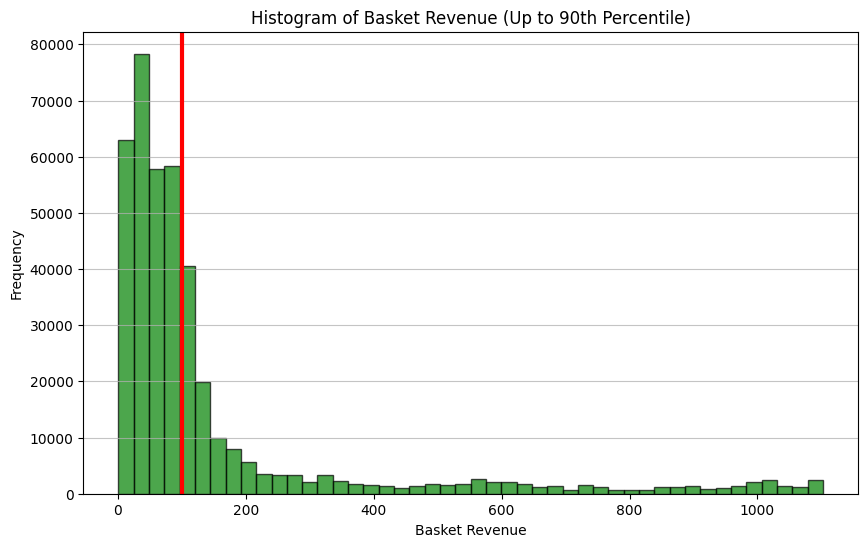

In [7]:
# Calculate the 0.90 percentile of the Basket Revenue to filter the data
percentile_90 = np.percentile(new_df['Basket Revenue'], 90)

# Filter the data to include only up to the 0.90 percentile
filtered_data = new_df[new_df['Basket Revenue'] <= percentile_90]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 90th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Baskets with "100TL üzeri çatı" campaign are rounded up to 100TL for baskets that have lower 'Basket Revenue' than 100TL

In [8]:
# Create a different subset based on the given conditions
subset_df = new_df.copy()

# Apply conditions: if 'CAMPAIGN' equals "100 TL üzeri çatı" in any items and 'Basket Revenue' < 100, set 'Basket Revenue' to 100
subset_df['Basket Revenue'] = subset_df.apply(
    lambda row: 100 if any(c == "100 TL üzeri çatı" for c in row['CAMPAIGN']) and row['Basket Revenue'] < 100 else row['Basket Revenue'],
    axis=1)

C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


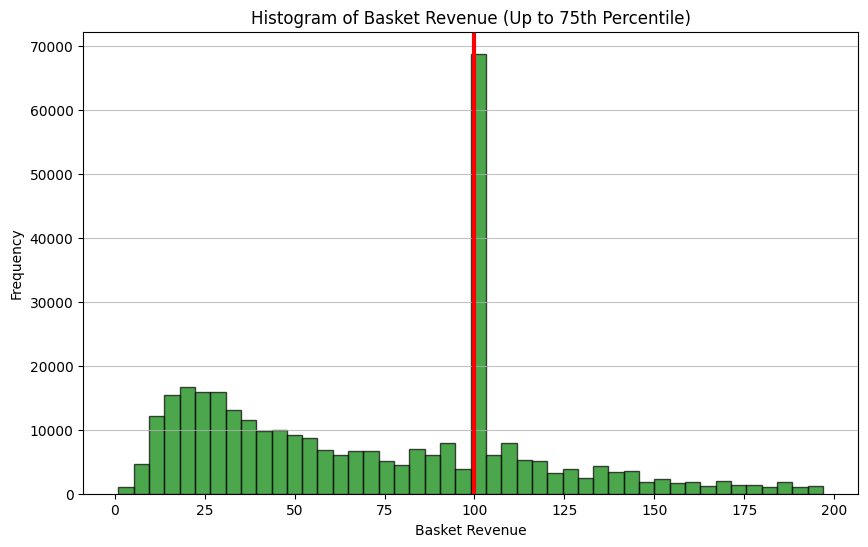

In [9]:
# Calculate the 0.75 percentile of the Basket Revenue to filter the data
percentile_75 = np.percentile(subset_df['Basket Revenue'], 75)

# Filter the data to include only up to the 0.90 percentile
filtered_data = subset_df[subset_df['Basket Revenue'] <= percentile_75]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 75th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Baskets with "100TL üzeri çatı" campaign with below 100TL 'Basket Revenue' are removed from the dataset (58270 baskets are removed)

In [10]:
# Adjusting approach to remove orders where 'CAMPAIGN' equals "100 TL üzeri çatı" and 'Basket Revenue' < 100

# Assuming 'new_df' has already been processed up to calculating 'Basket Revenue'
# and we have a column 'CAMPAIGN' that lists campaigns for each 'ORDER_ID'

# Define a function to check the condition and flag rows for removal
def should_remove_order(row):
    campaign_condition = any("100 TL üzeri çatı" in campaign for campaign in row['CAMPAIGN'])
    revenue_condition = row['Basket Revenue'] < 100
    return campaign_condition and revenue_condition

# Apply the function and add a 'Remove Order' flag to the dataframe
new_df['Remove Order'] = new_df.apply(should_remove_order, axis=1)

# Filter out the rows flagged for removal
filtered_df = new_df[~new_df['Remove Order']]

# Drop the 'Remove Order' column as it's no longer needed
filtered_df = filtered_df.drop(columns=['Remove Order'])

C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


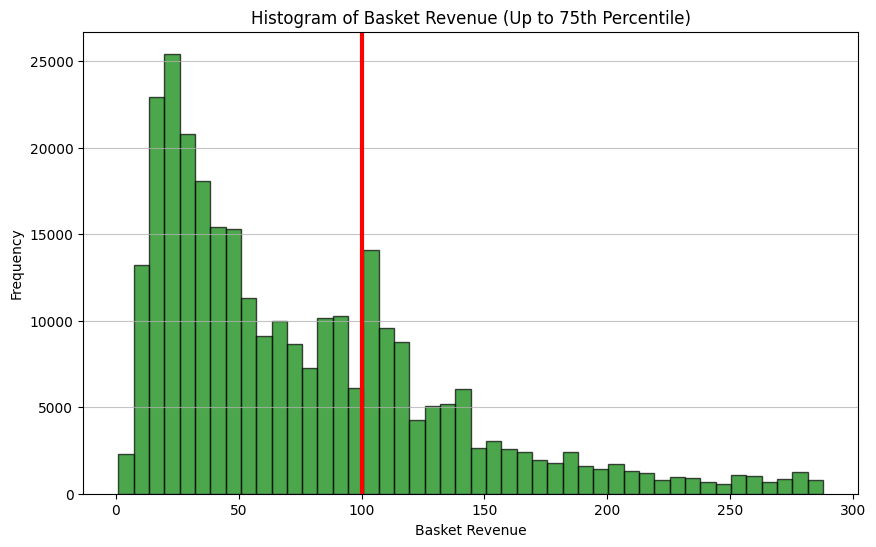

In [11]:
# Calculate the 0.75 percentile of the Basket Revenue to filter the data
percentile_75 = np.percentile(filtered_df['Basket Revenue'], 75)

# Filter the data to include only up to the 0.75 percentile
filtered_data = filtered_df[filtered_df['Basket Revenue'] <= percentile_75]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 75th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [12]:
#58270/105021 # of removed baskets / # of baskets with "100 TL üzeri çatı" campaign

# Same percentage of data is randomly removed from baskets (other than "100 TL üzeri çatı")  to protect the distribution of the initial data

In [13]:
# Correcting the approach without using sum for concatenation

# Separate into two subsets without causing a TypeError
sample_df = filtered_df.copy()
contains_campaign = sample_df[sample_df['CAMPAIGN'].apply(lambda x: "100 TL üzeri çatı" in x)]
does_not_contain_campaign = sample_df[sample_df['CAMPAIGN'].apply(lambda x: "100 TL üzeri çatı" not in x)]

# Randomly remove 55.5% of the rows from the subset without the campaign
rows_to_keep = does_not_contain_campaign.sample(frac=1-0.555, random_state=492)

# Merge the two subsets back together
merged_df = pd.concat([contains_campaign, rows_to_keep]).sort_index()

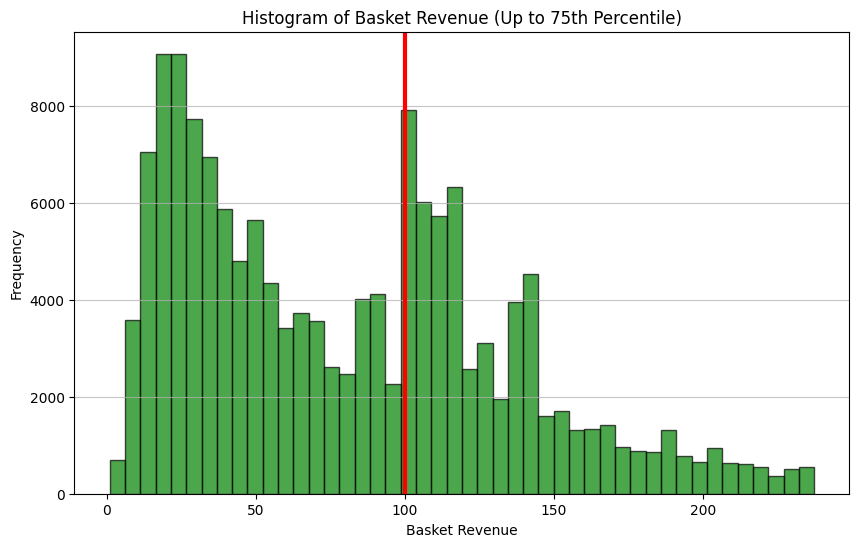

In [14]:
# Calculate the 0.75 percentile of the Basket Revenue to filter the data
percentile_75 = np.percentile(merged_df['Basket Revenue'], 75)

# Filter the data to include only up to the 0.75 percentile
filtered_data = merged_df[merged_df['Basket Revenue'] <= percentile_75]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 75th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

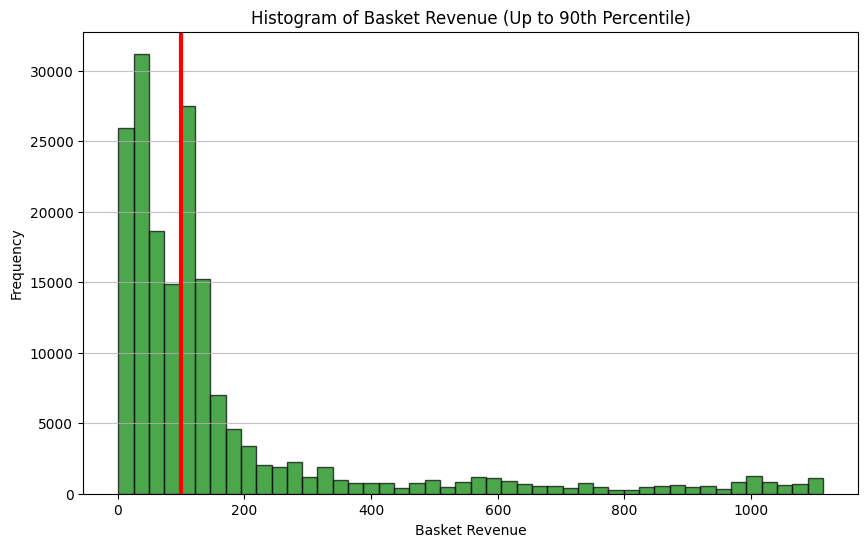

In [15]:
# Calculate the 0.90 percentile of the Basket Revenue to filter the data
percentile_90 = np.percentile(merged_df['Basket Revenue'], 90)

# Filter the data to include only up to the 0.75 percentile
filtered_data = merged_df[merged_df['Basket Revenue'] <= percentile_90]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 90th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Analyzing the effect of DESI on Real_SHC

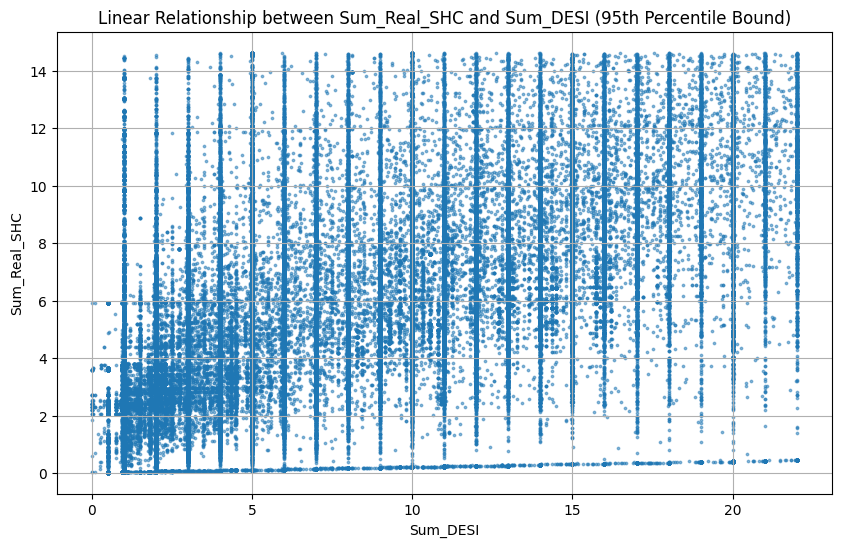

In [16]:
# Assuming new_df is the actual dataframe we want to work with, applying the percentile-based filtering

# Calculate the 95th percentile for both Sum_Real_SHC and Sum_DESI in the actual dataframe
upper_percentile_SHC_actual = new_df['Sum_Real_SHC'].quantile(0.95)
upper_percentile_DESI_actual = new_df['Sum_DESI'].quantile(0.95)

# Filter the actual dataframe to include only rows where both Sum_Real_SHC and Sum_DESI are below their respective 95th percentiles
filtered_df_percentile_actual = new_df[(new_df['Sum_Real_SHC'] <= upper_percentile_SHC_actual) & 
                                       (new_df['Sum_DESI'] <= upper_percentile_DESI_actual)]

# Plotting the filtered actual data without outliers above the 95th percentile
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df_percentile_actual['Sum_DESI'], filtered_df_percentile_actual['Sum_Real_SHC'], alpha=0.5, s=3)
plt.title('Linear Relationship between Sum_Real_SHC and Sum_DESI (95th Percentile Bound)')
plt.xlabel('Sum_DESI')
plt.ylabel('Sum_Real_SHC')
plt.grid(True)
plt.show()

In [17]:
correlation_coefficient = new_df['Sum_Real_SHC'].corr(new_df['Sum_DESI'])

# The Pearson correlation coefficient between Sum_Real_SHC and Sum_DESI is: 0.6938829633072248.

# ---------------------------------------------------------------------------------------------------------------

# Analyzing the Shipment Category of Baskets

In [18]:
real_free_shipping = 0
contingent_free_shipping = 0
paid_shipping = 0
mixed_shipping = 0

# Iterate through each row to check conditions
for index, row in merged_df.iterrows():
    # Check if all elements in FreeSH are True and all elements in CFreeSH are False
    if all(row['FreeSH']) and not any(row['CFreeSH']):
        real_free_shipping += 1
    # Check if all elements in FreeSH are False and all elements in CFreeSH are True
    elif not any(row['FreeSH']) and all(row['CFreeSH']):
        contingent_free_shipping += 1
    # Check if all elements in FreeSH are False and all elements in CFreeSH are False
    elif not any(row['FreeSH']) and not any(row['CFreeSH']):
        paid_shipping += 1
    # Otherwise, consider it as mixed shipping
    else:
        mixed_shipping += 1

print(f"Real Free Shipping: {real_free_shipping}")
print(f"Contingent Free Shipping: {contingent_free_shipping}")
print(f"Paid Shipping: {paid_shipping}")
print(f"Mixed Shipping: {mixed_shipping}")


C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


Real Free Shipping: 67335
Contingent Free Shipping: 34675
Paid Shipping: 85638
Mixed Shipping: 12236


In [19]:
# Define a function that categorizes each row based on the conditions provided
def categorize_shipping(row):
    if all(row['FreeSH']) and not any(row['CFreeSH']):
        return 'real_free_shipping'
    elif not any(row['FreeSH']) and all(row['CFreeSH']):
        return 'contingent_free_shipping'
    elif not any(row['FreeSH']) and not any(row['CFreeSH']):
        return 'paid_shipping'
    else:
        return 'mixed_shipping'

# Apply the function to each row of the DataFrame and create a new column with the result
merged_df['Shipping_Category'] = merged_df.apply(categorize_shipping, axis=1)
# Apply the function to each row of the DataFrame to create the new column
new_df['Shipping_Category'] = new_df.apply(categorize_shipping, axis=1)

# Divide PO and MP

def categorize_basket(seller):
    unique_sellers = set(seller)
    if unique_sellers == {'PO'}:
        return 'PO Only'
    elif unique_sellers == {'MP'}:
        return 'MP Only'
    else:
        return 'Mixed'

C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


# MO and MP Together (59655 baskets)

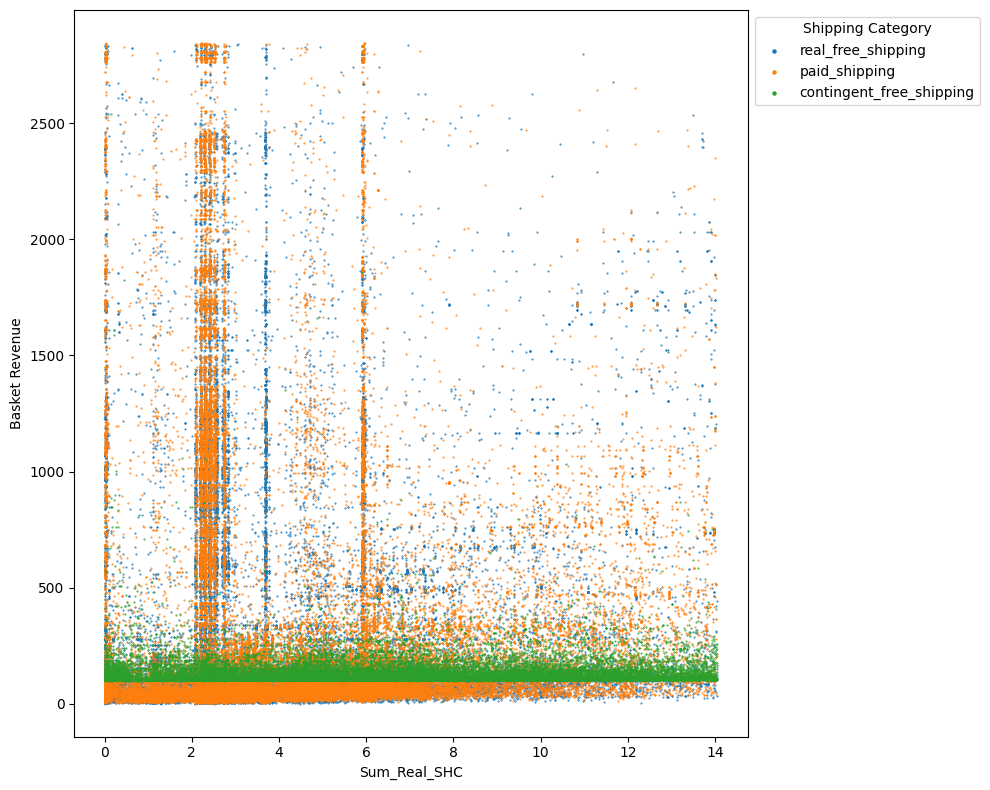

In [20]:
transactions_with_multiple_items = merged_df[merged_df['SUB_CATEGORY'].apply(len) > 1]

pd.options.mode.copy_on_write = True
transactions_with_multiple_items['Provider'] = transactions_with_multiple_items['Seller'].apply(categorize_basket)
transactions_with_multiple_items_mp = transactions_with_multiple_items[transactions_with_multiple_items['Provider'] == 'MP Only']
transactions_with_multiple_items_po = transactions_with_multiple_items[transactions_with_multiple_items['Provider'] == 'PO Only']

# Explode and calculate averages
exploded_transactions = transactions_with_multiple_items.explode('Category')
average_metrics_by_exploded_category = exploded_transactions.groupby('Category')[['Sum_Real_SHC', 'Basket Revenue']].mean()
average_metrics_dict = average_metrics_by_exploded_category.to_dict('index')

# Explode and calculate averages for MP Only transactions
mp_exploded_transactions = transactions_with_multiple_items_mp.explode('Category')
average_metrics_by_exploded_category_mp = mp_exploded_transactions.groupby('Category')[['Sum_Real_SHC', 'Basket Revenue']].mean()
average_metrics_mp_dict = average_metrics_by_exploded_category_mp.to_dict('index')

# Explode and calculate averages for PO Only transactions
po_exploded_transactions = transactions_with_multiple_items_po.explode('Category')
average_metrics_by_exploded_category_po = po_exploded_transactions.groupby('Category')[['Sum_Real_SHC', 'Basket Revenue']].mean()
average_metrics_po_dict = average_metrics_by_exploded_category_po.to_dict('index')
quantile_sum_real_shc = transactions_with_multiple_items['Sum_Real_SHC'].quantile(0.85)
quantile_basket_revenue = transactions_with_multiple_items['Basket Revenue'].quantile(0.982)

# Filter out outliers
df_filtered = merged_df[(merged_df['Sum_Real_SHC'] <= quantile_sum_real_shc) &
                      (merged_df['Basket Revenue'] <= quantile_basket_revenue)]

# Exclude 'mixed_shipping' from the filtered DataFrame
df_filtered = df_filtered[df_filtered['Shipping_Category'] != 'mixed_shipping']

# Plotting with an enlarged figure size
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed

# Now 'categories' will only include categories present in 'df_filtered', excluding 'mixed_shipping'
categories = df_filtered['Shipping_Category'].unique()

for category in categories:
    subset = df_filtered[df_filtered['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, s=0.2)  # Dot size in the plot

ax.set_xlabel('Sum_Real_SHC')
ax.set_ylabel('Basket Revenue')
# Placing the legend outside the plot on the right, enlarging the dots only in the legend
ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)  # Increase markerscale as needed
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

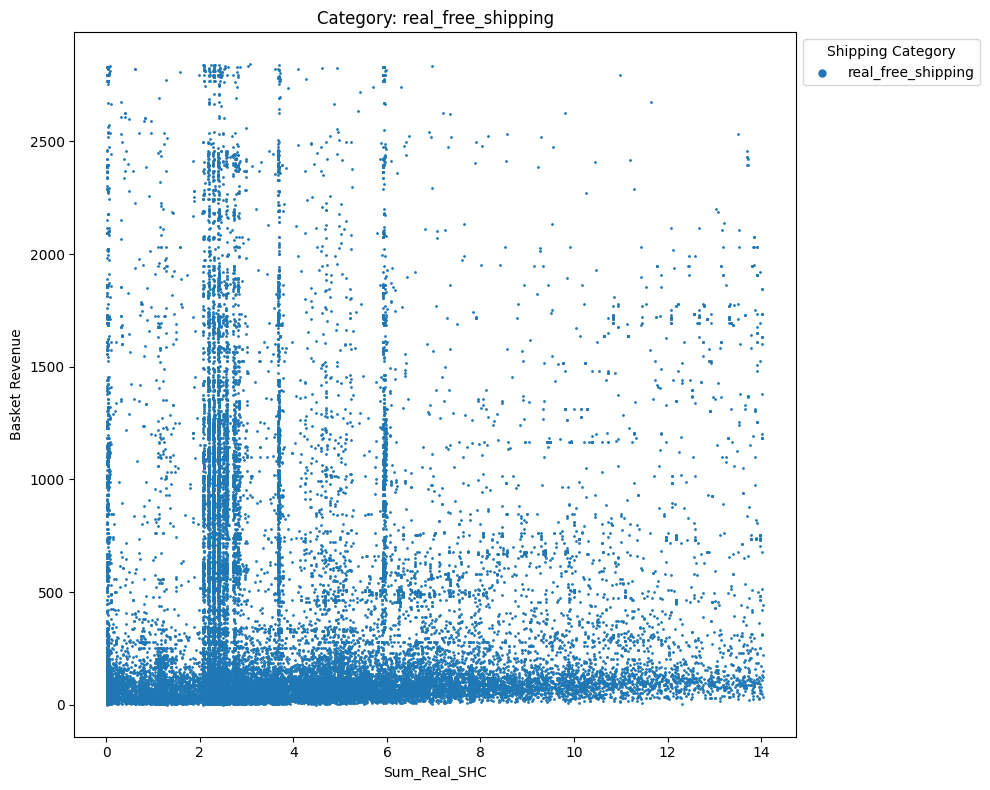

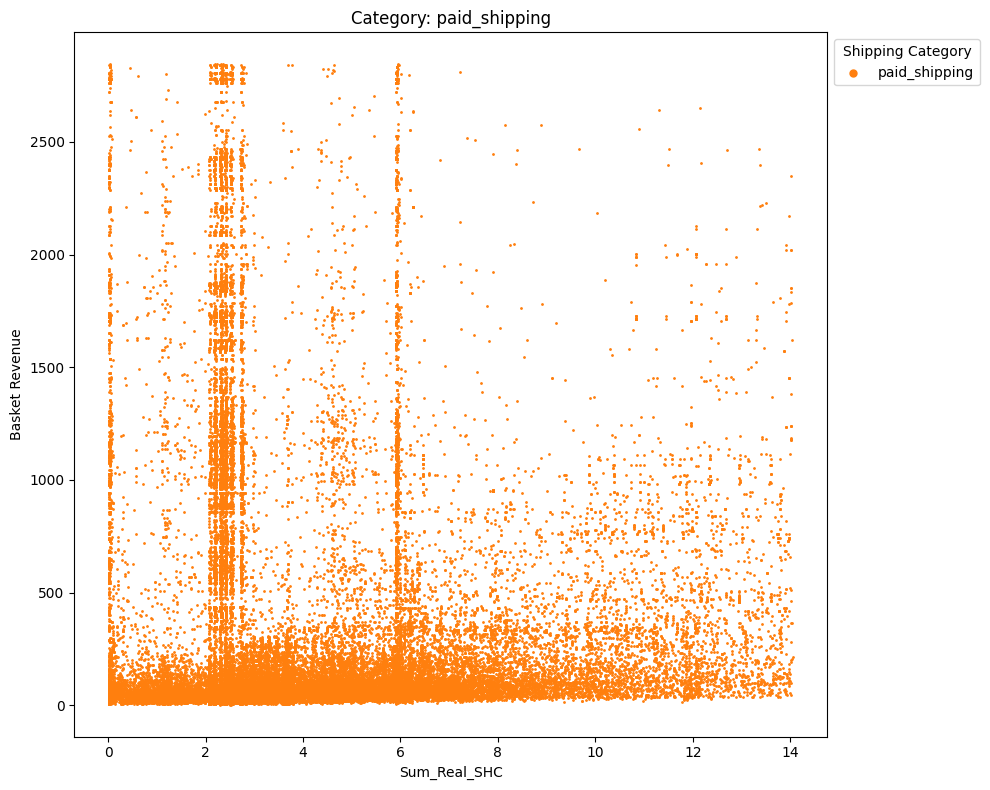

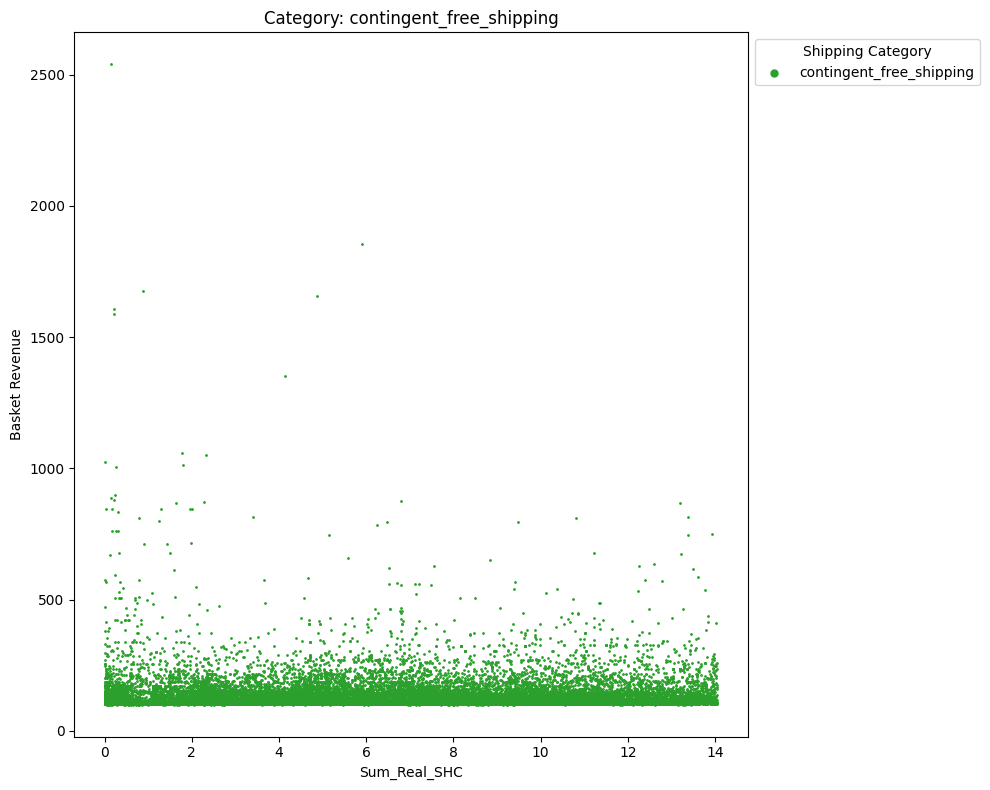

In [21]:
# Create a color map for consistent coloring across plots
categories = df_filtered['Shipping_Category'].unique()
color_map = {category: plt.cm.tab10(i) for i, category in enumerate(categories)}

# Plot separate graphs for each category using the color map
for category in categories:
    fig, ax = plt.subplots(figsize=(10, 8))
    subset = df_filtered[df_filtered['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, s=1, color=color_map[category])
    
    ax.set_xlabel('Sum_Real_SHC')
    ax.set_ylabel('Basket Revenue')
    ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)
    plt.title(f"Category: {category}")
    plt.tight_layout()
    plt.show()

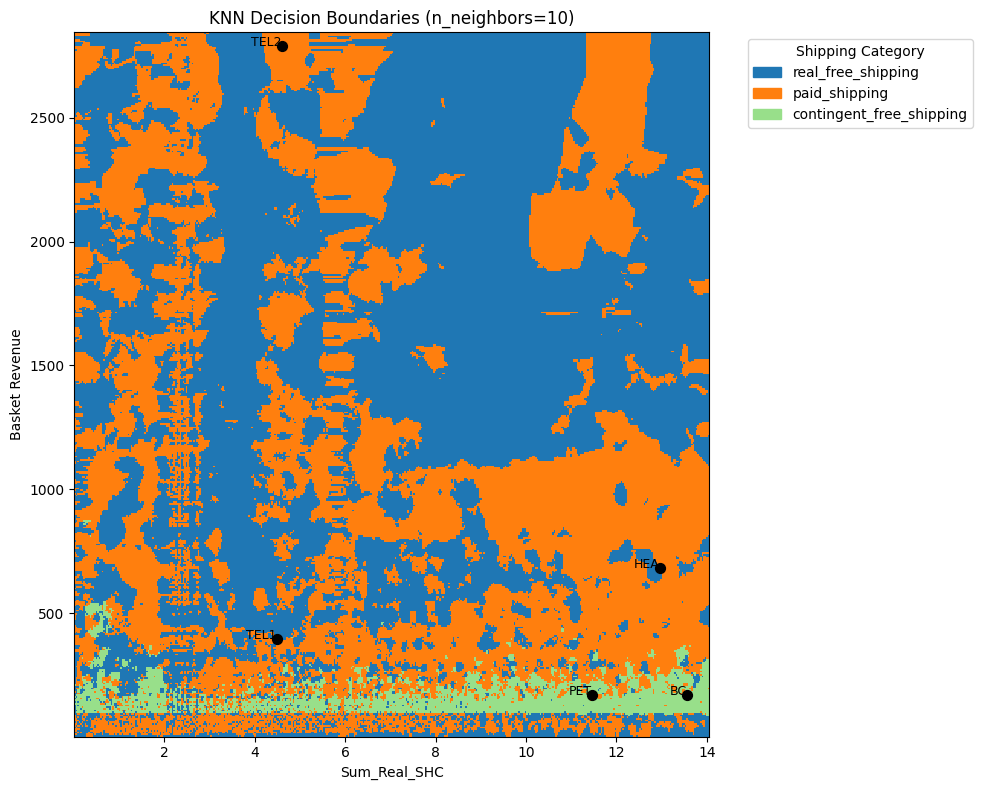

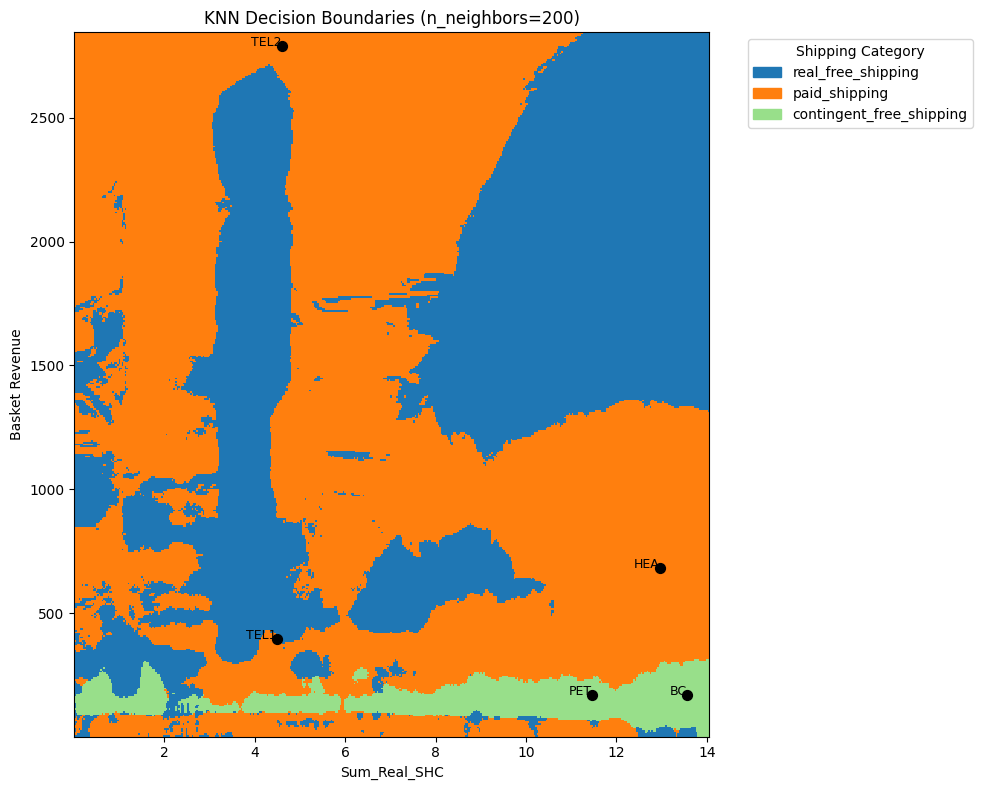

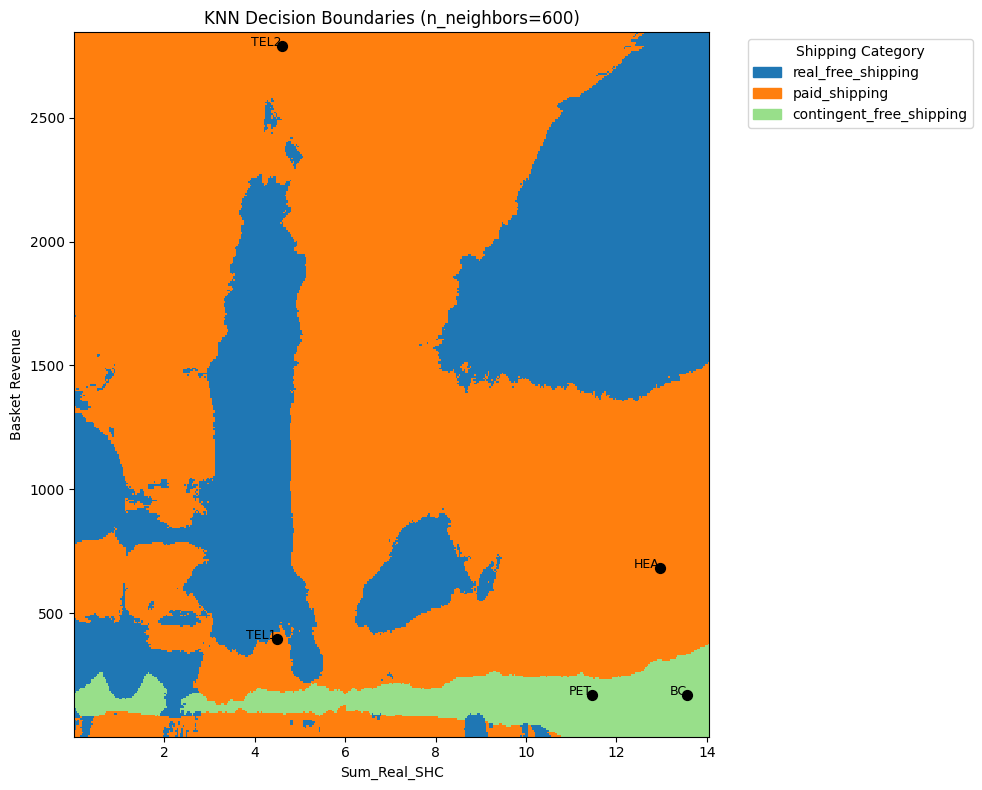

In [22]:
features = df_filtered[['Sum_Real_SHC', 'Basket Revenue']].values
target = df_filtered['Shipping_Category']
# Map string labels to integers
unique_labels = target.unique()
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
target_numeric = np.array([label_to_int[label] for label in target])

# Define the boundaries for the meshgrid
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1

# Create the meshgrid
# Determine the number of divisions you want along each axis
num_divisions = 500
h_x = (x_max - x_min) / num_divisions
h_y = (y_max - y_min) / num_divisions

xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))

# Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Update the meshgrid for the scaled features
x_min_scaled, x_max_scaled = 0 - 0.1, 1 + 0.1  # Since MinMaxScaler scales between 0 and 1
y_min_scaled, y_max_scaled = 0 - 0.1, 1 + 0.1
xx_scaled, yy_scaled = np.meshgrid(np.linspace(x_min_scaled, x_max_scaled, num_divisions),
                                   np.linspace(y_min_scaled, y_max_scaled, num_divisions))

def plot_knn_decision_boundaries_scaled(n_neighbors):
    # Fit the KNN classifier on normalized features
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features_scaled, target_numeric)

    # Predict over the scaled meshgrid
    Z = knn.predict(np.c_[xx_scaled.ravel(), yy_scaled.ravel()])
    Z_numeric = Z.reshape(xx_scaled.shape)

    # Inverse transform the scaled coordinates back to the original feature space for plotting
    meshgrid_scaled_points = np.vstack([xx_scaled.ravel(), yy_scaled.ravel()]).T
    meshgrid_original_points = scaler.inverse_transform(meshgrid_scaled_points)
    xx_original, yy_original = meshgrid_original_points[:, 0].reshape(xx_scaled.shape), meshgrid_original_points[:, 1].reshape(yy_scaled.shape)

    # Plot using the original feature space coordinates
    plt.figure(figsize=(10, 8))
    cmap_light = ListedColormap(['#1f77b4', '#ff7f0e', '#98df8a'])
    plt.pcolormesh(xx_original, yy_original, Z_numeric, cmap=cmap_light, shading='auto')
  
    # Check and plot average metrics if they fit within the plot limits
    x_min, x_max, y_min, y_max = plt.xlim()[0], plt.xlim()[1], plt.ylim()[0], plt.ylim()[1]
    for category, metrics in average_metrics_dict.items():
        if x_min <= metrics['Sum_Real_SHC'] <= x_max and y_min <= metrics['Basket Revenue'] <= y_max:
            plt.scatter(metrics['Sum_Real_SHC'], metrics['Basket Revenue'], color='black', s=50)  # Plot as a black dot
            plt.text(metrics['Sum_Real_SHC'], metrics['Basket Revenue'], category, color='black', fontsize=9, ha='right')
    
    # Set plot limits to the exact range of your original, non-normalized features
    plt.xlim(features[:, 0].min(), features[:, 0].max())
    plt.ylim(features[:, 1].min(), features[:, 1].max())
    plt.title(f"KNN Decision Boundaries (n_neighbors={n_neighbors})")
    plt.xlabel('Sum_Real_SHC')
    plt.ylabel('Basket Revenue')

    # Create legend handles manually
    handles = [mpatches.Patch(color=cmap_light.colors[i], label=int_to_label[i]) for i in range(len(unique_labels))]
    plt.legend(handles=handles, title='Shipping Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Call the function with different values of n_neighbors
plot_knn_decision_boundaries_scaled(10)
plot_knn_decision_boundaries_scaled(200)
plot_knn_decision_boundaries_scaled(600)

# MP Only (9883 baskets)

['paid_shipping' 'real_free_shipping']


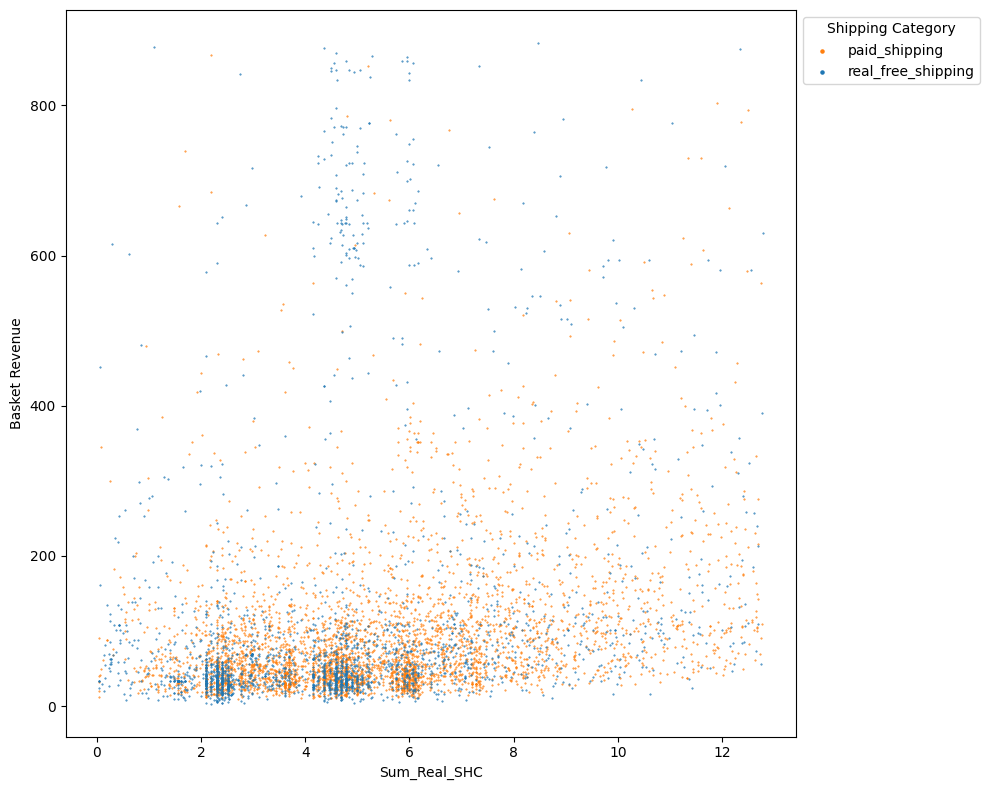

In [23]:
color_map = {
    'paid_shipping': '#ff7f0e',  # Orange
    'real_free_shipping': '#1f77b4',  # Blue
}

quantile_sum_real_shc_mp = transactions_with_multiple_items_mp['Sum_Real_SHC'].quantile(0.9)
quantile_basket_revenue_mp = transactions_with_multiple_items_mp['Basket Revenue'].quantile(0.9)

# Filter out outliers
df_filtered_mp = transactions_with_multiple_items_mp[(transactions_with_multiple_items_mp['Sum_Real_SHC'] <= quantile_sum_real_shc_mp) &
                      (transactions_with_multiple_items_mp['Basket Revenue'] <= quantile_basket_revenue_mp)]

# Exclude 'mixed_shipping' from the filtered DataFrame
df_filtered_mp = df_filtered_mp[df_filtered_mp['Shipping_Category'] != 'mixed_shipping']

# Plotting with an enlarged figure size
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed

# Now 'categories' will only include categories present in 'df_filtered', excluding 'mixed_shipping'
categories = df_filtered_mp['Shipping_Category'].unique()
print(categories)
for category in categories:
    subset = df_filtered_mp[df_filtered_mp['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, color=color_map.get(category, '#808080'), s=0.2)  # Dot size in the plot

ax.set_xlabel('Sum_Real_SHC')
ax.set_ylabel('Basket Revenue')
# Placing the legend outside the plot on the right, enlarging the dots only in the legend
ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)  # Increase markerscale as needed
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

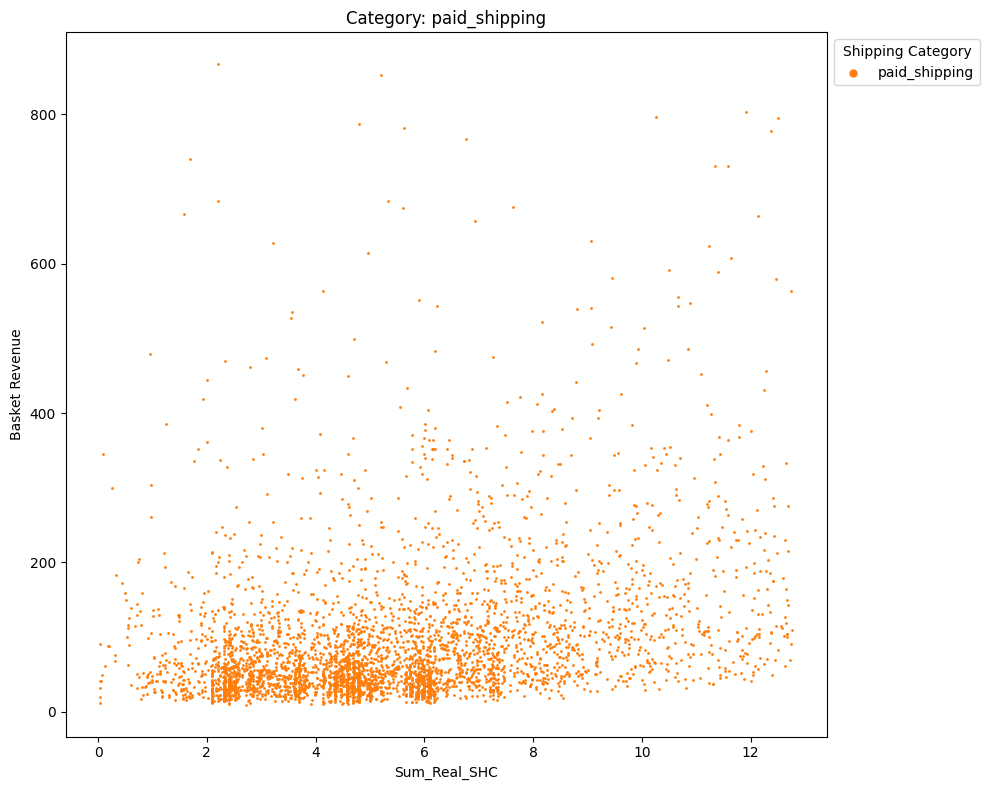

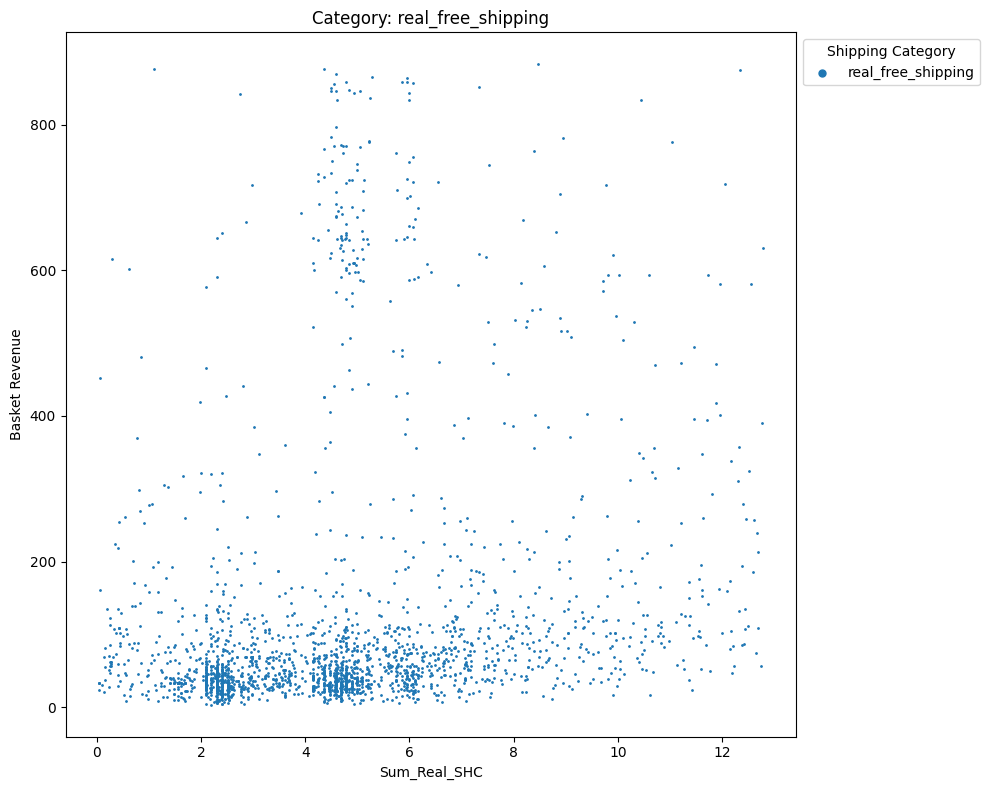

In [24]:
# Create a color map for consistent coloring across plots
categories_mp = df_filtered_mp['Shipping_Category'].unique()

# Plot separate graphs for each category using the color map
for category in categories_mp:
    fig, ax = plt.subplots(figsize=(10, 8))
    subset = df_filtered_mp[df_filtered_mp['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, s=1, color=color_map[category])
    
    ax.set_xlabel('Sum_Real_SHC')
    ax.set_ylabel('Basket Revenue')
    ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)
    plt.title(f"Category: {category}")
    plt.tight_layout()
    plt.show()

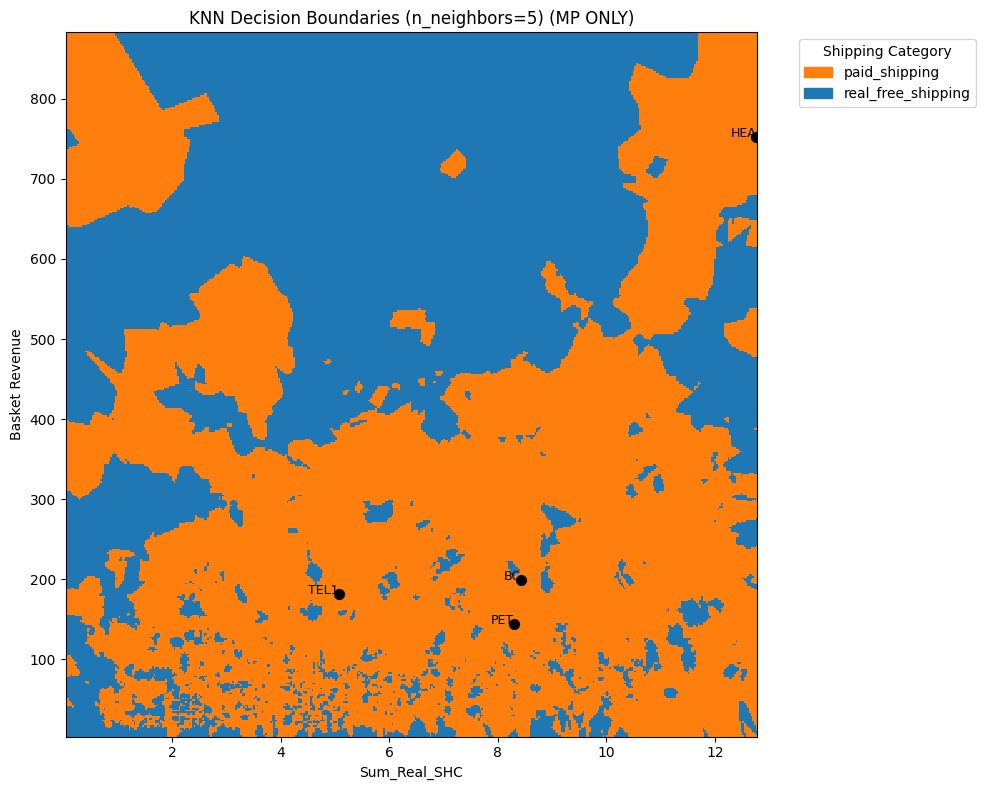

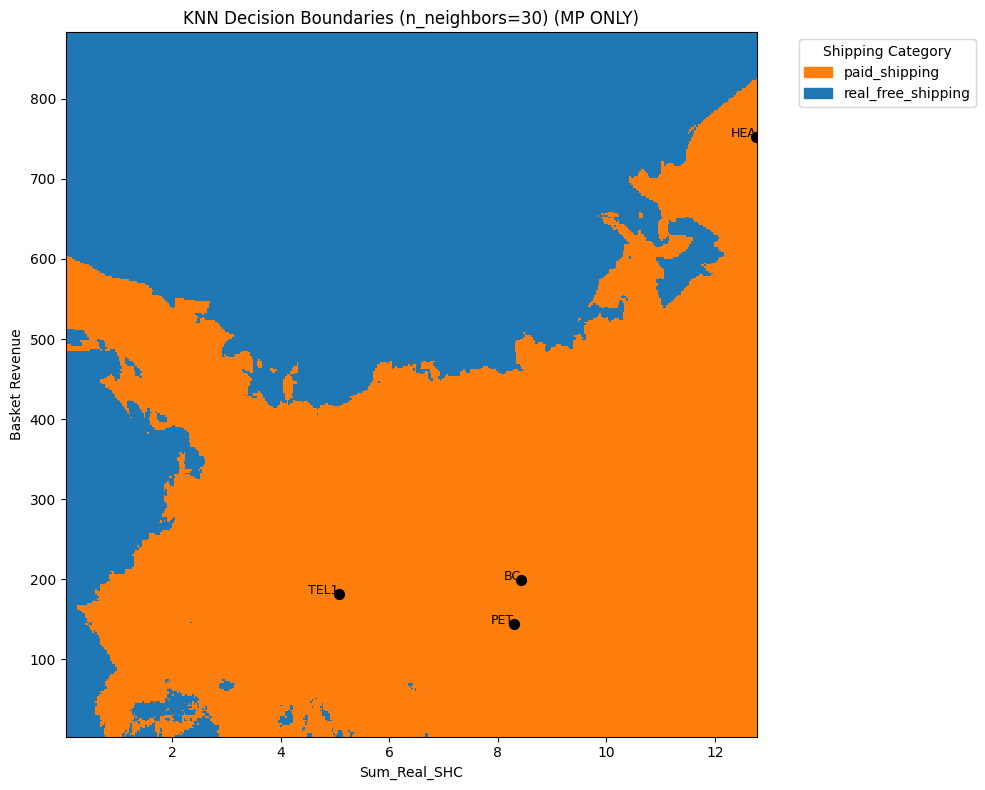

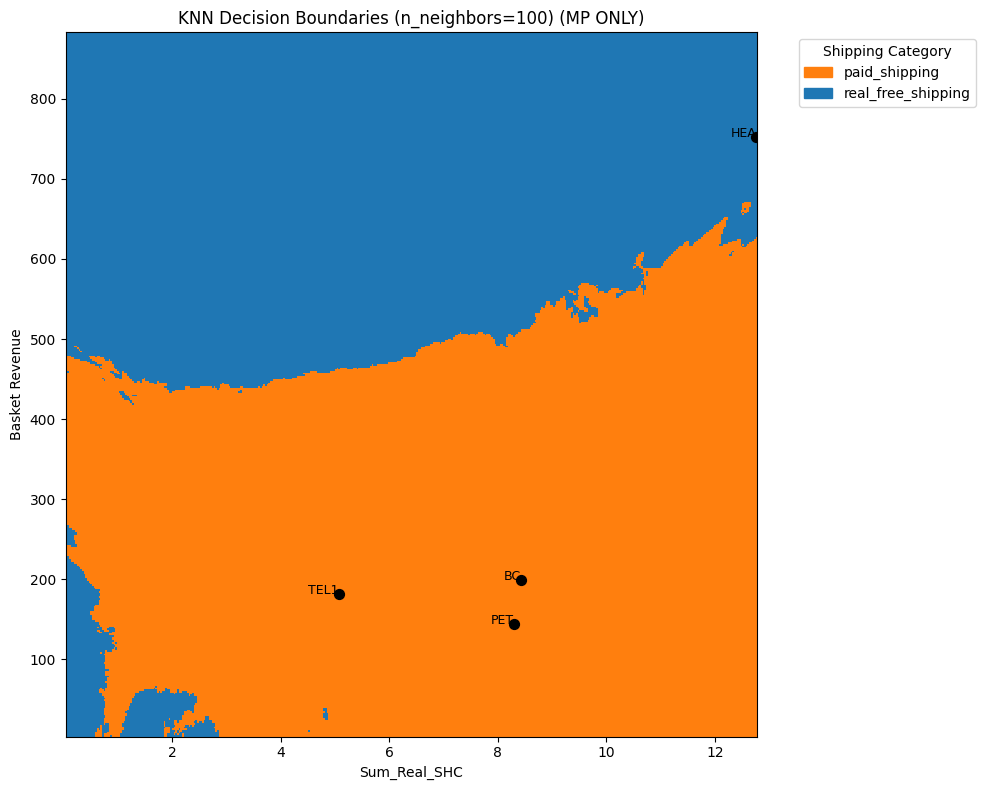

In [25]:
features_mp = df_filtered_mp[['Sum_Real_SHC', 'Basket Revenue']].values
target_mp = df_filtered_mp['Shipping_Category']
# Map string labels to integers
unique_labels_mp = target_mp.unique()
label_to_int_mp = {label: i for i, label in enumerate(unique_labels_mp)}
int_to_label_mp = {i: label for label, i in label_to_int_mp.items()}
target_numeric_mp = np.array([label_to_int_mp[label] for label in target_mp])

# Define the boundaries for the meshgrid
x_min_mp, x_max_mp = features_mp[:, 0].min() - 1, features_mp[:, 0].max() + 1
y_min_mp, y_max_mp = features_mp[:, 1].min() - 1, features_mp[:, 1].max() + 1

# Create the meshgrid
# Determine the number of divisions you want along each axis
num_divisions_mp = 500
h_x_mp = (x_max_mp - x_min_mp) / num_divisions_mp
h_y_mp = (y_max_mp - y_min_mp) / num_divisions_mp

xx_mp, yy_mp = np.meshgrid(np.arange(x_min_mp, x_max_mp, h_x_mp), np.arange(y_min_mp, y_max_mp, h_y_mp))

# Normalize the features
scaler = MinMaxScaler()
features_scaled_mp = scaler.fit_transform(features_mp)

# Update the meshgrid for the scaled features
x_min_scaled_mp, x_max_scaled_mp = 0 - 0.1, 1 + 0.1  # Since MinMaxScaler scales between 0 and 1
y_min_scaled_mp, y_max_scaled_mp = 0 - 0.1, 1 + 0.1
xx_scaled_mp, yy_scaled_mp = np.meshgrid(np.linspace(x_min_scaled_mp, x_max_scaled_mp, num_divisions_mp),
                                   np.linspace(y_min_scaled_mp, y_max_scaled_mp, num_divisions_mp))

def plot_knn_decision_boundaries_scaled_mp(n_neighbors):
    # Fit the KNN classifier on normalized features
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features_scaled_mp, target_numeric_mp)

    # Predict over the scaled meshgrid
    Z_mp = knn.predict(np.c_[xx_scaled_mp.ravel(), yy_scaled_mp.ravel()])
    Z_numeric_mp = Z_mp.reshape(xx_scaled_mp.shape)

    # Inverse transform the scaled coordinates back to the original feature space for plotting
    meshgrid_scaled_points_mp = np.vstack([xx_scaled_mp.ravel(), yy_scaled_mp.ravel()]).T
    meshgrid_original_points_mp = scaler.inverse_transform(meshgrid_scaled_points_mp)
    xx_original_mp, yy_original_mp = meshgrid_original_points_mp[:, 0].reshape(xx_scaled_mp.shape), meshgrid_original_points_mp[:, 1].reshape(yy_scaled_mp.shape)

    # Plot using the original feature space coordinates
    plt.figure(figsize=(10, 8))
    cmap_light = ListedColormap(['#ff7f0e', '#1f77b4'])
    plt.pcolormesh(xx_original_mp, yy_original_mp, Z_numeric_mp, cmap=cmap_light, shading='auto')

    # Check and plot average metrics if they fit within the plot limits
    x_min, x_max, y_min, y_max = plt.xlim()[0], plt.xlim()[1], plt.ylim()[0], plt.ylim()[1]
    for category, metrics in average_metrics_mp_dict.items():
        if x_min <= metrics['Sum_Real_SHC'] <= x_max and y_min <= metrics['Basket Revenue'] <= y_max:
            plt.scatter(metrics['Sum_Real_SHC'], metrics['Basket Revenue'], color='black', s=50)  # Plot as a black dot
            plt.text(metrics['Sum_Real_SHC'], metrics['Basket Revenue'], category, color='black', fontsize=9, ha='right')
    
    # Set plot limits to the exact range of your original, non-normalized features
    plt.xlim(features_mp[:, 0].min(), features_mp[:, 0].max())
    plt.ylim(features_mp[:, 1].min(), features_mp[:, 1].max())
    plt.title(f"KNN Decision Boundaries (n_neighbors={n_neighbors}) (MP ONLY)")
    plt.xlabel('Sum_Real_SHC')
    plt.ylabel('Basket Revenue')

    # Create legend handles manually
    handles = [mpatches.Patch(color=cmap_light.colors[i], label=int_to_label_mp[i]) for i in range(len(unique_labels_mp))]
    plt.legend(handles=handles, title='Shipping Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Call the function with different values of n_neighbors
plot_knn_decision_boundaries_scaled_mp(5)
plot_knn_decision_boundaries_scaled_mp(30)
plot_knn_decision_boundaries_scaled_mp(100)

# PO (34148 baskets)

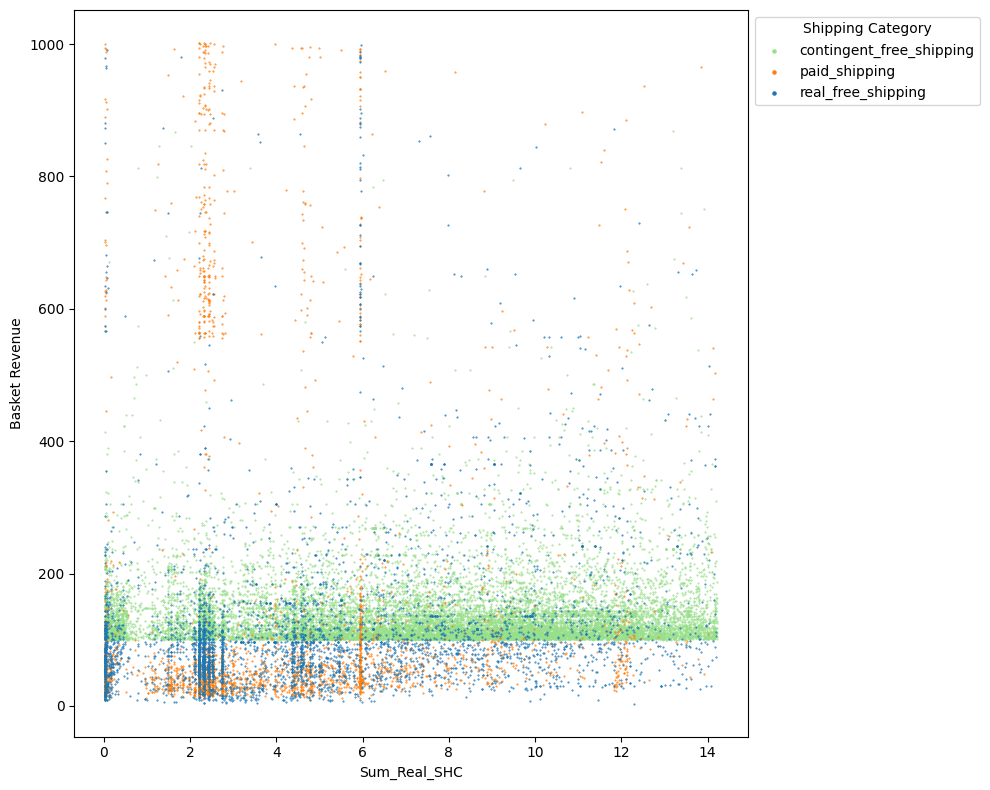

In [26]:
color_map = {
    'paid_shipping': '#ff7f0e',  # Orange
    'real_free_shipping': '#1f77b4',  # Blue
    'contingent_free_shipping': '#98df8a'  # Green
}
quantile_sum_real_shc_po = transactions_with_multiple_items_po['Sum_Real_SHC'].quantile(0.85)
quantile_basket_revenue_po = transactions_with_multiple_items_po['Basket Revenue'].quantile(0.924)

# Filter out outliers
df_filtered_po = transactions_with_multiple_items_po[(transactions_with_multiple_items_po['Sum_Real_SHC'] <= quantile_sum_real_shc_po) &
                      (transactions_with_multiple_items_po['Basket Revenue'] <= quantile_basket_revenue_po)]

# Exclude 'mixed_shipping' from the filtered DataFrame
df_filtered_po = df_filtered_po[df_filtered_po['Shipping_Category'] != 'mixed_shipping']

# Plotting with an enlarged figure size
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed

# Now 'categories' will only include categories present in 'df_filtered', excluding 'mixed_shipping'
categories = df_filtered_po['Shipping_Category'].unique()

for category in categories:
    subset = df_filtered_po[df_filtered_po['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, color=color_map[category], s=0.2)  # Dot size in the plot

ax.set_xlabel('Sum_Real_SHC')
ax.set_ylabel('Basket Revenue')
# Placing the legend outside the plot on the right, enlarging the dots only in the legend
ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)  # Increase markerscale as needed
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

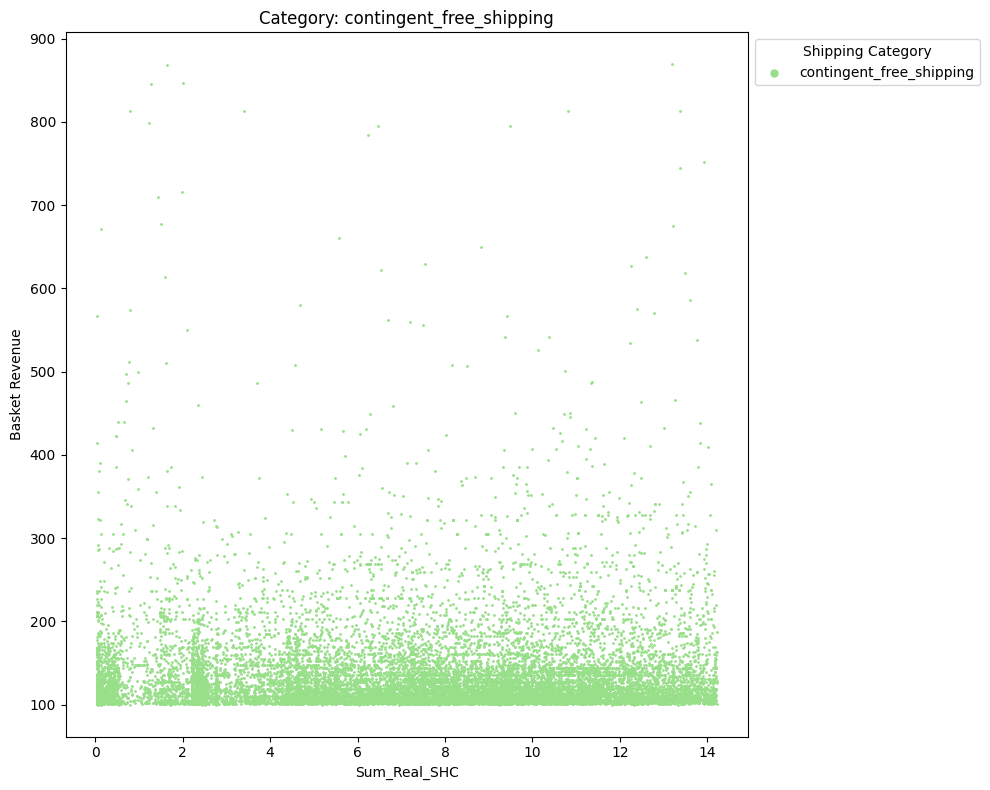

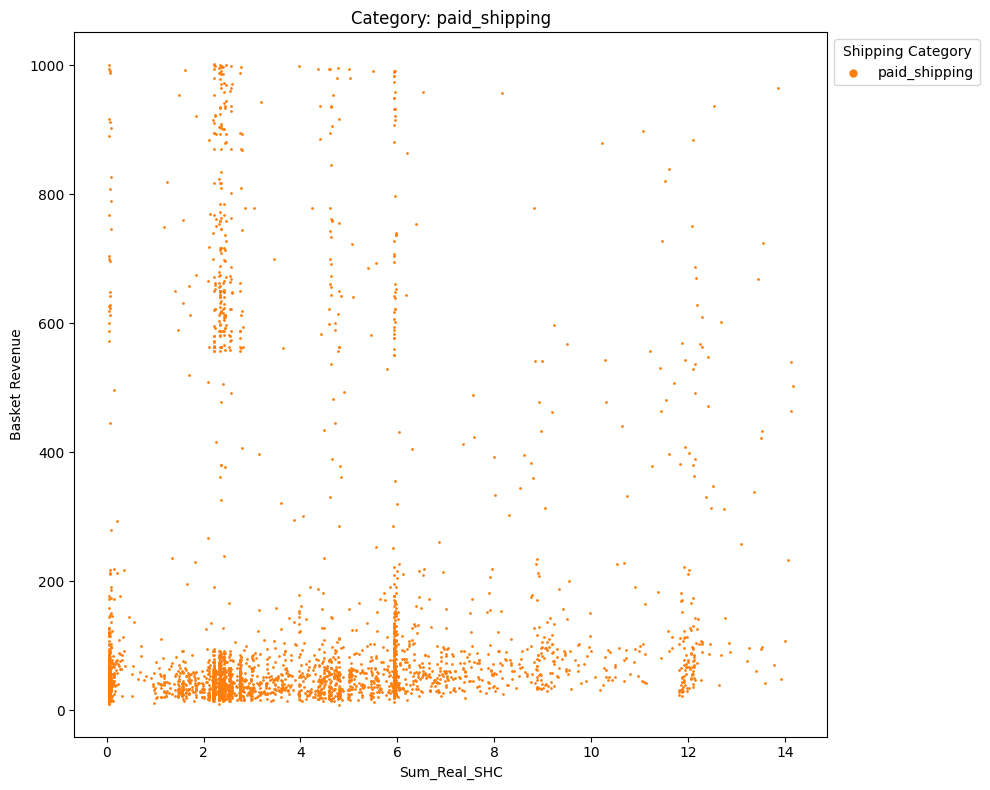

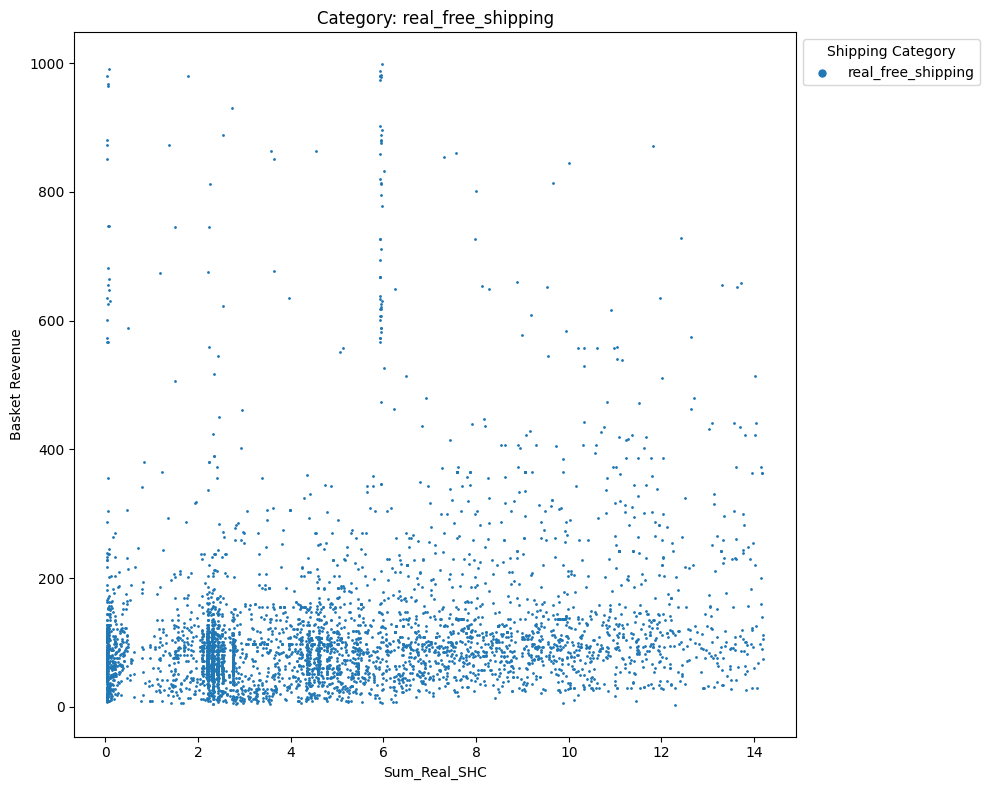

In [27]:
# Create a color map for consistent coloring across plots
categories_po = df_filtered_po['Shipping_Category'].unique()

# Plot separate graphs for each category using the color map
for category in categories_po:
    fig, ax = plt.subplots(figsize=(10, 8))
    subset = df_filtered_po[df_filtered_po['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, s=1, color=color_map[category])
    
    ax.set_xlabel('Sum_Real_SHC')
    ax.set_ylabel('Basket Revenue')
    ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)
    plt.title(f"Category: {category}")
    plt.tight_layout()
    plt.show()

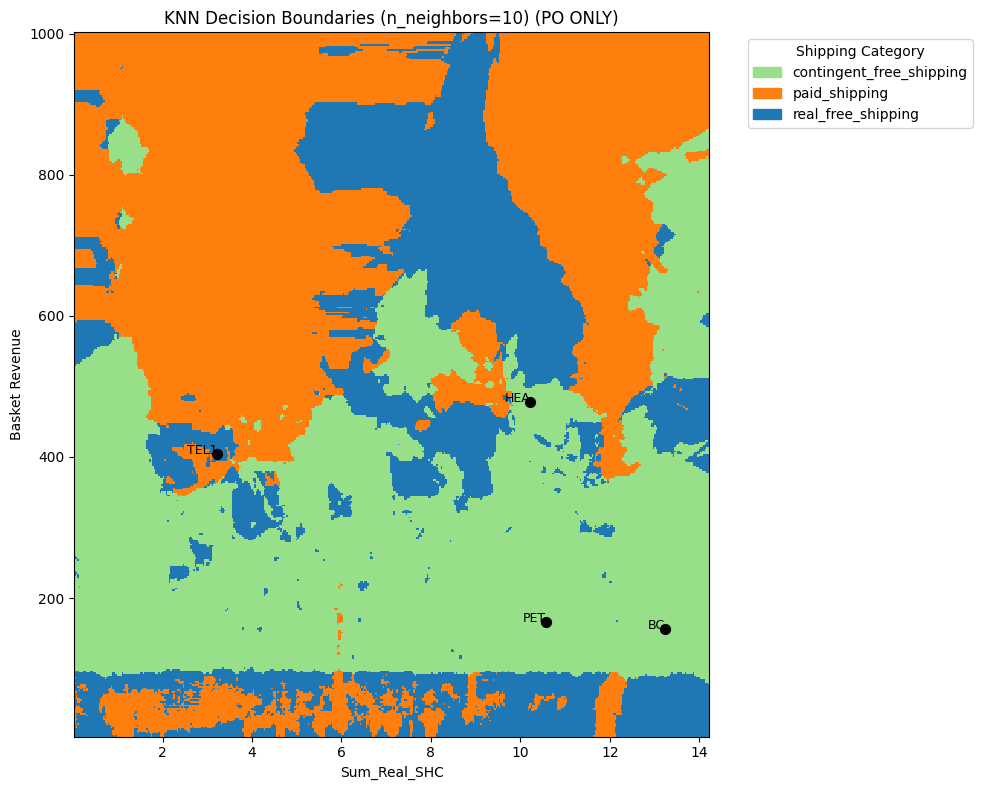

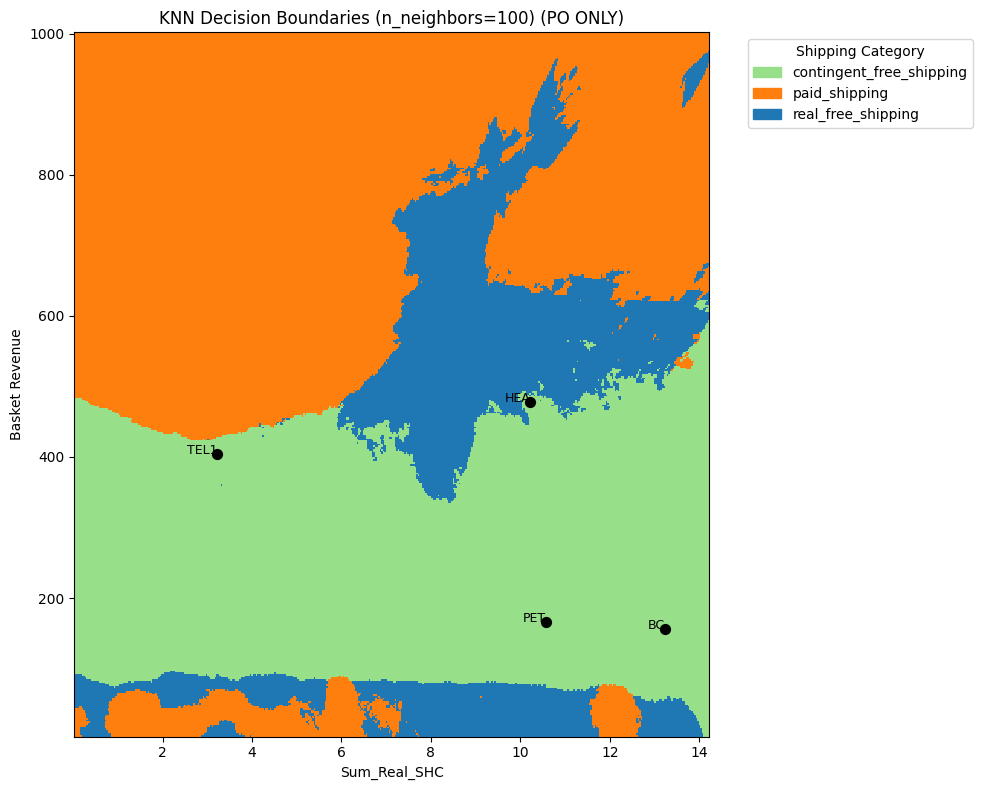

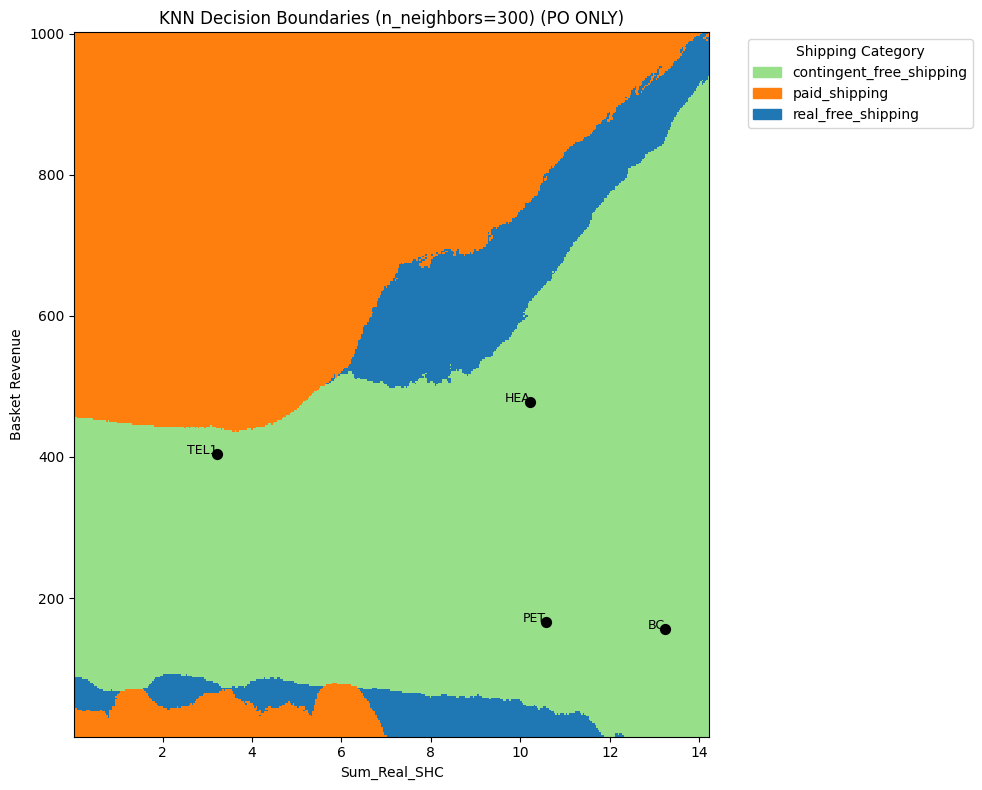

In [28]:
features_po = df_filtered_po[['Sum_Real_SHC', 'Basket Revenue']].values
target_po = df_filtered_po['Shipping_Category']
# Map string labels to integers
unique_labels_po = target_po.unique()
label_to_int_po = {label: i for i, label in enumerate(unique_labels_po)}
int_to_label_po = {i: label for label, i in label_to_int_po.items()}
target_numeric_po = np.array([label_to_int_po[label] for label in target_po])

# Define the boundaries for the meshgrid
x_min_po, x_max_po = features_po[:, 0].min() - 1, features_po[:, 0].max() + 1
y_min_po, y_max_po = features_po[:, 1].min() - 1, features_po[:, 1].max() + 1

# Create the meshgrid
# Determine the number of divisions you want along each axis
num_divisions_po = 500
h_x_po = (x_max_po - x_min_po) / num_divisions_po
h_y_po = (y_max_po - y_min_po) / num_divisions_po

xx_po, yy_po = np.meshgrid(np.arange(x_min_po, x_max_po, h_x_po), np.arange(y_min_po, y_max_po, h_y_po))

# Normalize the features
scaler = MinMaxScaler()
features_scaled_po = scaler.fit_transform(features_po)

# Update the meshgrid for the scaled features
x_min_scaled_po, x_max_scaled_po = 0 - 0.1, 1 + 0.1  # Since MinMaxScaler scales between 0 and 1
y_min_scaled_po, y_max_scaled_po = 0 - 0.1, 1 + 0.1
xx_scaled_po, yy_scaled_po = np.meshgrid(np.linspace(x_min_scaled_po, x_max_scaled_po, num_divisions_po),
                                   np.linspace(y_min_scaled_po, y_max_scaled_po, num_divisions_po))

def plot_knn_decision_boundaries_scaled_po(n_neighbors):
    # Fit the KNN classifier on normalized features
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features_scaled_po, target_numeric_po)

    # Predict over the scaled meshgrid
    Z_po = knn.predict(np.c_[xx_scaled_po.ravel(), yy_scaled_po.ravel()])
    Z_numeric_po = Z_po.reshape(xx_scaled_po.shape)

    # Inverse transform the scaled coordinates back to the original feature space for plotting
    meshgrid_scaled_points_po = np.vstack([xx_scaled_po.ravel(), yy_scaled_po.ravel()]).T
    meshgrid_original_points_po = scaler.inverse_transform(meshgrid_scaled_points_po)
    xx_original_po, yy_original_po = meshgrid_original_points_po[:, 0].reshape(xx_scaled_po.shape), meshgrid_original_points_po[:, 1].reshape(yy_scaled_po.shape)

    # Plot using the original feature space coordinates
    plt.figure(figsize=(10, 8))
    cmap_light = ListedColormap(['#98df8a', '#ff7f0e', '#1f77b4'])
    plt.pcolormesh(xx_original_po, yy_original_po, Z_numeric_po, cmap=cmap_light, shading='auto')

    # Check and plot average metrics if they fit within the plot limits
    x_min, x_max, y_min, y_max = plt.xlim()[0], plt.xlim()[1], plt.ylim()[0], plt.ylim()[1]
    for category, metrics in average_metrics_po_dict.items():
        if x_min <= metrics['Sum_Real_SHC'] <= x_max and y_min <= metrics['Basket Revenue'] <= y_max:
            plt.scatter(metrics['Sum_Real_SHC'], metrics['Basket Revenue'], color='black', s=50)  # Plot as a black dot
            plt.text(metrics['Sum_Real_SHC'], metrics['Basket Revenue'], category, color='black', fontsize=9, ha='right')
            
    # Set plot limits to the exact range of your original, non-normalized features
    plt.xlim(features_po[:, 0].min(), features_po[:, 0].max())
    plt.ylim(features_po[:, 1].min(), features_po[:, 1].max())
    plt.title(f"KNN Decision Boundaries (n_neighbors={n_neighbors}) (PO ONLY)")
    plt.xlabel('Sum_Real_SHC')
    plt.ylabel('Basket Revenue')

    # Create legend handles manually
    handles = [mpatches.Patch(color=cmap_light.colors[i], label=int_to_label_po[i]) for i in range(len(unique_labels_po))]
    plt.legend(handles=handles, title='Shipping Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Call the function with different values of n_neighbors
plot_knn_decision_boundaries_scaled_po(10)
plot_knn_decision_boundaries_scaled_po(100)
plot_knn_decision_boundaries_scaled_po(300)

# ---------------------------------------------------------------------------------------------------------------

# Time Series Analysis (Category-Based) of Daily Revenues to see "Weekend" effect

In [29]:
daily_revenue_by_category_weekend = df.groupby(['DATE', 'Category', 'Weekend'])['Revenue'].sum().reset_index()
daily_revenue_by_category_weekend

,DATE,Category,Weekend,Revenue
0,2017-03-01,BC,False,115624.87
1,2017-03-01,HEA,False,533457.91
2,2017-03-01,PET,False,76866.07
3,2017-03-01,TEL1,False,130159.51
4,2017-03-01,TEL2,False,1950022.14
...,...,...,...,...
300,2017-04-30,BC,True,165042.40
301,2017-04-30,HEA,True,315769.92
302,2017-04-30,PET,True,42001.08
303,2017-04-30,TEL1,True,86657.71


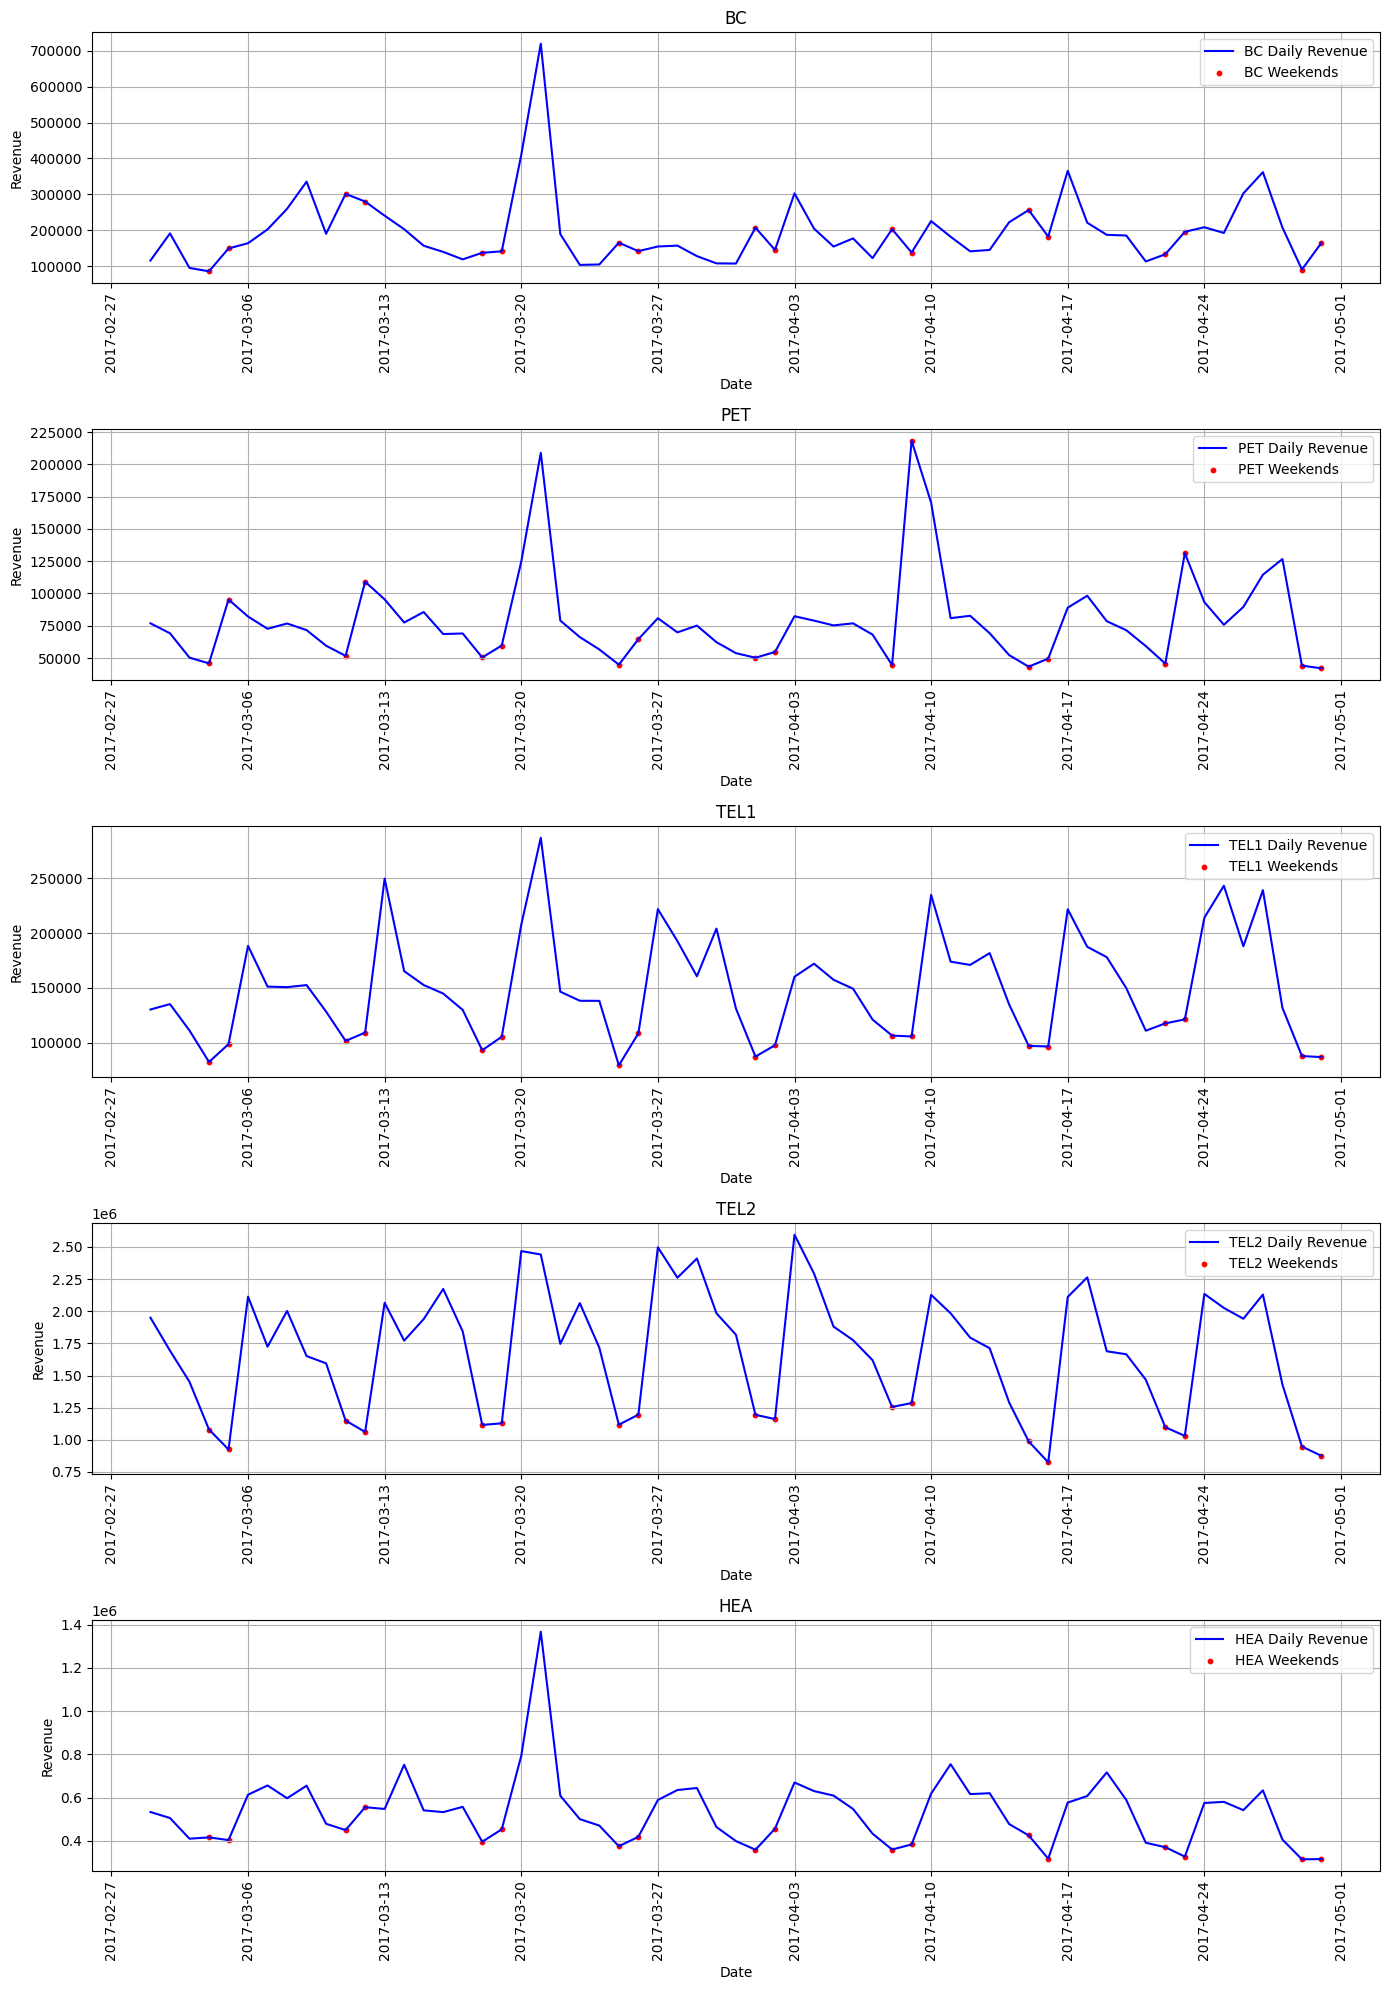

In [30]:
plt.figure(figsize=(14, 20))

categories = df["Category"].unique()
for i, category in enumerate(categories, start=1):
    plt.subplot(len(categories), 1, i)
    category_data = daily_revenue_by_category_weekend[daily_revenue_by_category_weekend['Category'] == category]
    
    # Plot all data as a line
    plt.plot(category_data['DATE'], category_data['Revenue'], label=f"{category} Daily Revenue", color='blue')
    
    # Mark weekend data points based on 'Weekend' column
    weekend_data = category_data[category_data['Weekend'] == True]
    plt.scatter(weekend_data['DATE'], weekend_data['Revenue'], label=f"{category} Weekends", color='red', s=10)  # s is the size of the marker
    
    plt.title(category)
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    weekly_locator = WeekdayLocator(byweekday=MO)
    formatter = DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_locator(weekly_locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    plt.tight_layout()

plt.show()

# Time Series Analysis (Campaign-Based) of Daily Revenues

In [31]:
# Grouping by 'DATE', 'CAMPAIGN', and 'Weekend' to sum the revenues
grouped_revenue = df.groupby(['DATE', 'CAMPAIGN', 'Weekend'])['Revenue'].sum().reset_index()

# Calculating total daily revenue
daily_total_revenue = grouped_revenue.groupby('DATE')['Revenue'].sum().reset_index()
daily_total_revenue = daily_total_revenue.rename(columns={'Revenue': 'Total_Daily_Revenue'})

# Merging to get total daily revenue back into our grouped dataframe
grouped_revenue_with_total = pd.merge(grouped_revenue, daily_total_revenue, on='DATE')

# Calculating the percentage
grouped_revenue_with_total['Percentage'] = (grouped_revenue_with_total['Revenue'] / grouped_revenue_with_total['Total_Daily_Revenue']) * 100

grouped_revenue_with_total

,DATE,CAMPAIGN,Weekend,Revenue,Total_Daily_Revenue,Percentage
0,2017-03-01,100 TL üzeri çatı,False,120148.78,2806130.50,4.281653
1,2017-03-01,Kampanya Modülü Kampanyası,False,632065.59,2806130.50,22.524455
2,2017-03-01,Kargo Bedava Ürün Kampanyası,False,27054.57,2806130.50,0.964124
3,2017-03-01,Other,False,989356.83,2806130.50,35.256979
4,2017-03-01,Ürüne Sabit Ücretli Kargo,False,1037504.73,2806130.50,36.972790
...,...,...,...,...,...,...
331,2017-04-30,Desi Bazlı Kargo Ücreti,True,149710.33,1484505.55,10.084862
332,2017-04-30,Kampanya Modülü Kampanyası,True,531525.09,1484505.55,35.804857
333,2017-04-30,Kargo Bedava Ürün Kampanyası,True,29975.10,1484505.55,2.019198
334,2017-04-30,Other,True,429219.02,1484505.55,28.913265


In [32]:
campaigns = df['CAMPAIGN'].unique()
campaigns

array(['100 TL üzeri çatı', 'Kampanya Modülü Kampanyası', 'Other',
       'Kargo Bedava Ürün Kampanyası', 'Ürüne Sabit Ücretli Kargo',
       'Desi Bazlı Kargo Ücreti', 'Maliyetsiz Kargo Bedava'], dtype=object)

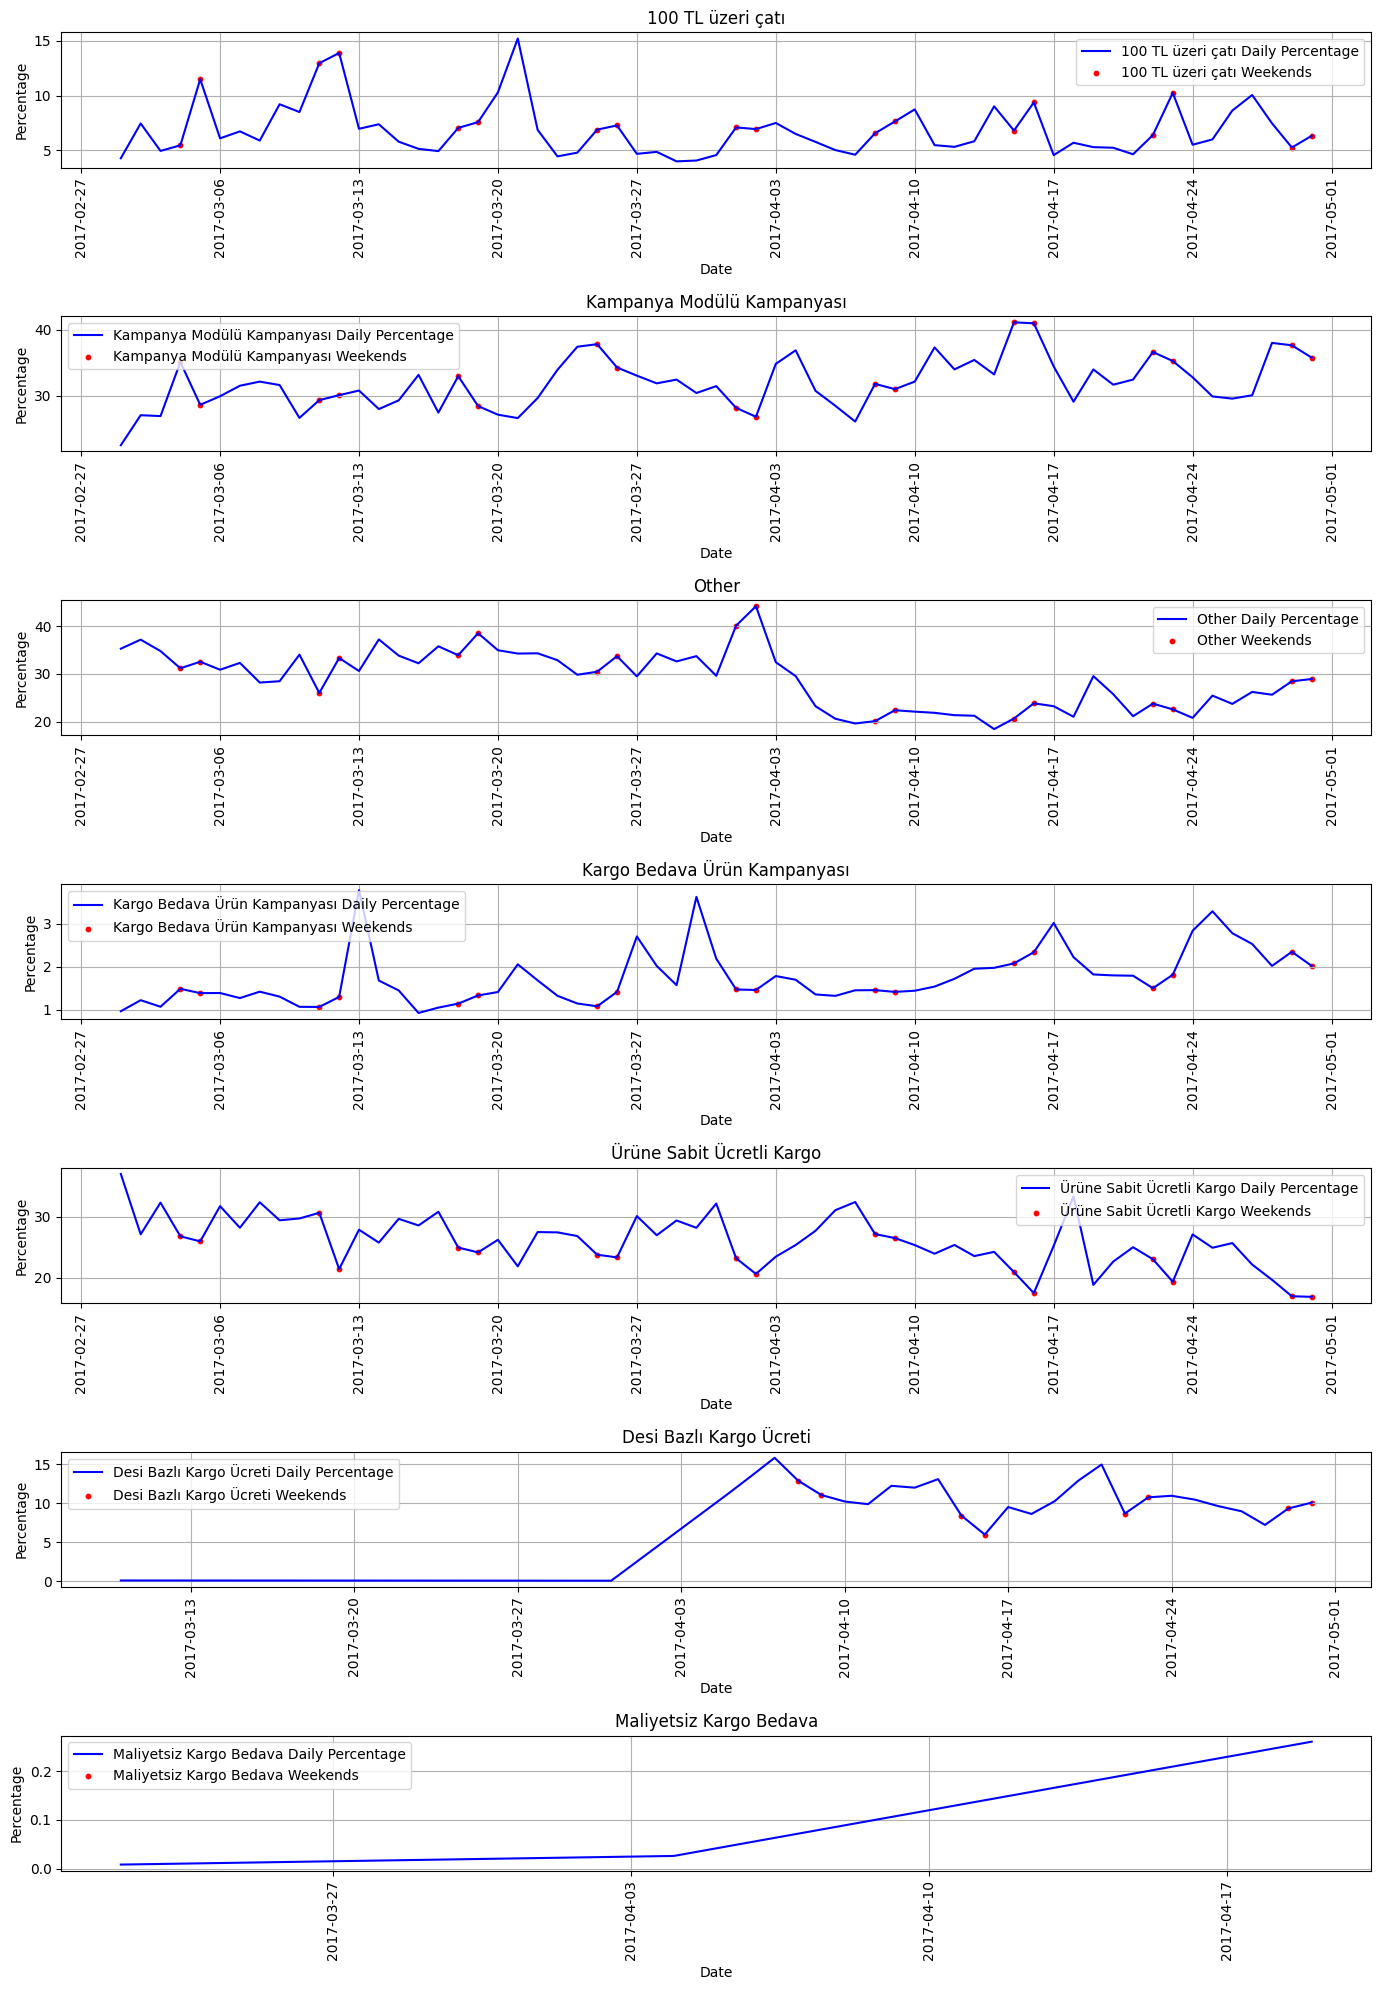

In [33]:
plt.figure(figsize=(14, 20))

for i, campaign in enumerate(campaigns, start=1):
    plt.subplot(len(campaigns), 1, i)
    campaign_data = grouped_revenue_with_total[grouped_revenue_with_total['CAMPAIGN'] == campaign]
    
    # Plot all data as a line
    plt.plot(campaign_data['DATE'], campaign_data['Percentage'], label=f"{campaign} Daily Percentage", color='blue')
    
    # Mark weekend data points based on 'Weekend' column
    weekend_data = campaign_data[campaign_data['Weekend'] == True]
    plt.scatter(weekend_data['DATE'], weekend_data['Percentage'], label=f"{campaign} Weekends", color='red', s=10)  # s is the size of the marker
    
    plt.title(campaign)
    plt.xlabel('Date')
    plt.ylabel('Percentage')
    weekly_locator = WeekdayLocator(byweekday=MO)
    formatter = DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_locator(weekly_locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    plt.tight_layout()

plt.show()

# Market Basket Analysis with Apriori Algorithm (According to Sub Category)

## All Shipping Categories

In [34]:
# Prepare the list of sub-category lists for the apriori algorithm
transactions = transactions_with_multiple_items['SUB_CATEGORY'].tolist()

encoder = TransactionEncoder()
transactions_encoded = encoder.fit_transform(transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets = apriori(transactions_df, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted.head())

     support                                        itemsets
15  0.286699              (Deterjan ve Temizlik Malzemeleri)
8   0.226117                                    (Bebek Bezi)
51  0.221088                              (Telefon Kılıflar)
11  0.102456                                  (Cep Telefonu)
68  0.086816  (Deterjan ve Temizlik Malzemeleri, Bebek Bezi)


In [35]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted = rules.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted.head())

                                    antecedents  \
15                       (Ek Güvence Paketleri)   
105  (Sarf Tüketim Malzemeleri, Kağıt Ürünleri)   
97                 (Gıda Ürünü, Kağıt Ürünleri)   
108                 (Kağıt Ürünleri, İçecekler)   
27                             (Kağıt Ürünleri)   

                            consequents  antecedent support  \
15                       (Cep Telefonu)            0.004224   
105  (Deterjan ve Temizlik Malzemeleri)            0.004107   
97   (Deterjan ve Temizlik Malzemeleri)            0.009035   
108  (Deterjan ve Temizlik Malzemeleri)            0.007325   
27   (Deterjan ve Temizlik Malzemeleri)            0.074663   

     consequent support   support  confidence      lift  leverage  conviction  \
15             0.102456  0.004224    1.000000  9.760308  0.003791         inf   
105            0.286699  0.003470    0.844898  2.946991  0.002292    4.598917   
97             0.286699  0.007024    0.777365  2.711439  0.004433    3.

## Real Free Shipping

In [36]:
# Prepare the list of sub-category lists for the apriori algorithm
rfs_transactions = transactions_with_multiple_items[transactions_with_multiple_items['Shipping_Category'] == 'real_free_shipping']
cfs_transactions = transactions_with_multiple_items[transactions_with_multiple_items['Shipping_Category'] == 'contingent_free_shipping']
ps_transactions = transactions_with_multiple_items[transactions_with_multiple_items['Shipping_Category'] == 'paid_shipping']

transactions_rfs_list = rfs_transactions['SUB_CATEGORY'].tolist()
transactions_cfs_list = cfs_transactions['SUB_CATEGORY'].tolist()
transactions_ps_list = ps_transactions['SUB_CATEGORY'].tolist()


encoder = TransactionEncoder()
transactions_encoded_rfs = encoder.fit_transform(transactions_rfs_list)
transactions_df_rfs = pd.DataFrame(transactions_encoded_rfs, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_rfs = apriori(transactions_df_rfs, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_rfs = frequent_itemsets_rfs.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_rfs.head())

     support                            itemsets
39  0.282333                  (Telefon Kılıflar)
11  0.251271  (Deterjan ve Temizlik Malzemeleri)
6   0.172968                        (Bebek Bezi)
8   0.104558                      (Cep Telefonu)
19  0.070907                       (Kedi Maması)


In [37]:
# Generate association rules
rules_rfs = association_rules(frequent_itemsets_rfs, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_rfs = rules_rfs.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_rfs.head())

                     antecedents         consequents  antecedent support  \
8         (Ek Güvence Paketleri)      (Cep Telefonu)            0.003790   
50          (Tv Askı Aparatları)    (LCD Televizyon)            0.008505   
42          (Kuş Bakım Ürünleri)       (Kuş Yemleri)            0.005824   
10                (Cep Telefonu)  (Telefon Kılıflar)            0.104558   
35  (Kedi Ödüller ve Vitaminler)       (Kedi Maması)            0.014699   

    consequent support   support  confidence       lift  leverage  conviction  \
8             0.104558  0.003790    1.000000   9.564103  0.003394         inf   
50            0.017195  0.007950    0.934783  54.363137  0.007804   15.069674   
42            0.012665  0.004437    0.761905  60.157108  0.004364    4.146806   
10            0.282333  0.069982    0.669319   2.370670  0.040462    2.170270   
35            0.070907  0.009799    0.666667   9.401999  0.008757    2.787279   

    zhangs_metric  
8        0.898849  
50       0.99002

## Contingent Free Shipping

In [38]:
transactions_encoded_cfs = encoder.fit_transform(transactions_cfs_list)
transactions_df_cfs = pd.DataFrame(transactions_encoded_cfs, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_cfs = apriori(transactions_df_cfs, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_cfs = frequent_itemsets_cfs.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_cfs.head())

     support                                           itemsets
11  0.499084                 (Deterjan ve Temizlik Malzemeleri)
6   0.433692                                       (Bebek Bezi)
49  0.171904     (Deterjan ve Temizlik Malzemeleri, Bebek Bezi)
13  0.141420                                   (Kağıt Ürünleri)
61  0.115407  (Deterjan ve Temizlik Malzemeleri, Kağıt Ürünl...


In [39]:
# Generate association rules
rules_cfs = association_rules(frequent_itemsets_cfs, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_cfs = rules_cfs.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_cfs.head())

                                    antecedents  \
87   (Sarf Tüketim Malzemeleri, Kağıt Ürünleri)   
31                   (Sarf Tüketim Malzemeleri)   
79                 (Gıda Ürünü, Kağıt Ürünleri)   
90                  (Kağıt Ürünleri, İçecekler)   
105     (Gıda Ürünü, Kağıt Ürünleri, İçecekler)   

                            consequents  antecedent support  \
87   (Deterjan ve Temizlik Malzemeleri)            0.006481   
31   (Deterjan ve Temizlik Malzemeleri)            0.009789   
79   (Deterjan ve Temizlik Malzemeleri)            0.015912   
90   (Deterjan ve Temizlik Malzemeleri)            0.013409   
105  (Deterjan ve Temizlik Malzemeleri)            0.006705   

     consequent support   support  confidence      lift  leverage  conviction  \
87             0.499084  0.006034    0.931034  1.865488  0.002799    7.263286   
31             0.499084  0.008850    0.904110  1.811539  0.003965    5.223841   
79             0.499084  0.013454    0.845506  1.694116  0.005512    3.

## Paid Shipping

In [40]:
transactions_encoded_ps = encoder.fit_transform(transactions_ps_list)
transactions_df_ps = pd.DataFrame(transactions_encoded_ps, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_ps = apriori(transactions_df_ps, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_ps = frequent_itemsets_ps.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_ps.head())

     support                            itemsets
58  0.283506                  (Telefon Kılıflar)
13  0.154262                      (Cep Telefonu)
76  0.112446    (Telefon Kılıflar, Cep Telefonu)
27  0.103943                       (Kedi Maması)
16  0.089395  (Deterjan ve Temizlik Malzemeleri)


In [41]:
# Generate association rules
rules_ps = association_rules(frequent_itemsets_ps, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_ps = rules_ps.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_ps.head())

               antecedents           consequents  antecedent support  \
14  (Ek Güvence Paketleri)        (Cep Telefonu)            0.010472   
16          (Cep Telefonu)    (Telefon Kılıflar)            0.154262   
75    (Tv Askı Aparatları)      (LCD Televizyon)            0.017218   
38             (Kedi Kumu)         (Kedi Maması)            0.069787   
74        (LCD Televizyon)  (Tv Askı Aparatları)            0.017921   

    consequent support   support  confidence       lift  leverage  conviction  \
14            0.154262  0.010472    1.000000   6.482460  0.008856         inf   
16            0.283506  0.112446    0.728929   2.571129  0.068712    2.643202   
75            0.017921  0.011526    0.669388  37.351837  0.011217    2.970485   
38            0.103943  0.045400    0.650554   6.258777  0.038146    2.564222   
74            0.017218  0.011526    0.643137  37.351837  0.011217    2.753949   

    zhangs_metric  
14       0.854688  
16       0.722524  
75       0.990279  


# Interpretation of Lift:
Lift = 1: A and B occur together just as often as we would expect if they were independent. There's no association between the items.

Lift > 1: A and B occur together more often than expected, indicating a positive relationship between the items. The higher the lift, the stronger the association.

Lift < 1: A and B occur together less often than expected, suggesting a substitute or negative relationship between the items.

# Market Basket Analysis with Apriori Algorithm (According to SKU)

## All Shipping Categories

In [42]:
transactions_with_multiple_skus = new_df[new_df['PRODUCT_NAME'].apply(len) > 1]

# Prepare the list of SKU lists for the apriori algorithm
transactions = transactions_with_multiple_skus['PRODUCT_NAME'].tolist()

# Use the TransactionEncoder to encode the transactions
encoder = TransactionEncoder()
transactions_encoded = encoder.fit_transform(transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

# Apply the apriori algorithm to find frequent itemsets based on SKUs
frequent_itemsets = apriori(transactions_df, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted.head())

     support                                           itemsets
74  0.040417  (Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...
33  0.032120  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...
10  0.029117  (Ariel Toz Çamaşır Deterjanı Dağ Esintisi 9 kg...
72  0.021173  (Prima Bebek Bezi Aktif Bebek 4 Beden Maxi Ayl...
43  0.020075  (Finish Powerball Quantum Bulaşık Makinesi Det...


In [43]:
# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted = rules.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted.head())

                                          antecedents  \
9    (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)   
8   (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...   
23               (Uni Baby Çamaşır Deterjanı 1500 ml)   
21                        (Solo Tuvalet Kağıdı 32 li)   
24              (Uni Baby Çamaşır Yumuşatıcı 1500 ml)   

                                          consequents  antecedent support  \
9   (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...            0.009834   
8    (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)            0.011880   
23              (Uni Baby Çamaşır Yumuşatıcı 1500 ml)            0.008148   
21                     (Solo Ultra Kağıt Havlu 12 li)            0.008132   
24               (Uni Baby Çamaşır Deterjanı 1500 ml)            0.009990   

    consequent support   support  confidence       lift  leverage  conviction  \
9             0.011880  0.006117    0.622010  52.356372  0.006000    2.614139   
8             0.009834  0.006117

## Real Free Shipping

In [44]:
transactions_rfs_list = rfs_transactions['PRODUCT_NAME'].tolist()
transactions_cfs_list = cfs_transactions['PRODUCT_NAME'].tolist()
transactions_ps_list = ps_transactions['PRODUCT_NAME'].tolist()

encoder = TransactionEncoder()
transactions_encoded_rfs = encoder.fit_transform(transactions_rfs_list)
transactions_df_rfs = pd.DataFrame(transactions_encoded_rfs, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_rfs = apriori(transactions_df_rfs, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_rfs = frequent_itemsets_rfs.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_rfs.head())

      support                                           itemsets
57   0.025700  (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...
24   0.023019  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...
115  0.021725           (Xiaomi Mi Band 2 Akıllı Bileklik Siyah)
91   0.020523  (Spigen Araç Tutacağı Manyetik Evrensel Tüm Ci...
58   0.018767   (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)


In [45]:
# Generate association rules
rules_rfs = association_rules(frequent_itemsets_rfs, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_rfs = rules_rfs.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_rfs.head())

                                          antecedents  \
37  (Xiaomi 20000 mAh Taşınabilir Şarj Cihazı Sili...   
39    (Xiaomi Mi Band 2 Akıllı Bileklik Kordonu Mavi)   
35  (Xiaomi 10000 mAh Taşınabilir Şarj Cihazı Siya...   
21   (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)   
19  (Molfix Bebek Bezi Comfort Fix Süper Fırsat Pa...   

                                          consequents  antecedent support  \
37         (Xiaomi 20000 mAh Taşınabilir Şarj Cihazı)            0.003421   
39           (Xiaomi Mi Band 2 Akıllı Bileklik Siyah)            0.005639   
35         (Xiaomi 10000 mAh Taşınabilir Şarj Cihazı)            0.003513   
21  (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...            0.018767   
19  (Molfix Bebek Bezi Comfort Fix Süper Fırsat Pa...            0.005824   

    consequent support   support  confidence        lift  leverage  \
37            0.006934  0.003328    0.972973  140.328649  0.003304   
39            0.021725  0.005454    0.967213   44.5206

## Contingent Free Shipping

In [46]:
transactions_encoded_cfs = encoder.fit_transform(transactions_cfs_list)
transactions_df_cfs = pd.DataFrame(transactions_encoded_cfs, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_cfs = apriori(transactions_df_cfs, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_cfs = frequent_itemsets_cfs.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_cfs.head())

      support                                           itemsets
119  0.118983  (Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...
13   0.101909  (Ariel Toz Çamaşır Deterjanı Dağ Esintisi 9 kg...
44   0.100881  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...
116  0.069056  (Prima Bebek Bezi Aktif Bebek 4 Beden Maxi Ayl...
62   0.059313  (Finish Powerball Quantum Bulaşık Makinesi Det...


In [47]:
# Generate association rules
rules_cfs = association_rules(frequent_itemsets_cfs, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_cfs = rules_cfs.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_cfs.head())

                                           antecedents  \
126  (Fairy Hepsi Bir Arada Bulaşık Makinesi Deterj...   
95   (Xiaomi 20000 mAh Taşınabilir Şarj Cihazı Sili...   
96   (Xiaomi Mi Band 2 Akıllı Bileklik Kordonu Aske...   
128  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...   
98    (Xiaomi Mi Band 2 Akıllı Bileklik Kordonu Yeşil)   

                                           consequents  antecedent support  \
126  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...            0.003084   
95          (Xiaomi 20000 mAh Taşınabilir Şarj Cihazı)            0.005855   
96            (Xiaomi Mi Band 2 Akıllı Bileklik Siyah)            0.005721   
128  (Fairy Hepsi Bir Arada Bulaşık Makinesi Deterj...            0.003173   
98            (Xiaomi Mi Band 2 Akıllı Bileklik Siyah)            0.003442   

     consequent support   support  confidence       lift  leverage  \
126            0.100881  0.003039    0.985507   9.769053  0.002728   
95             0.011621  0.005721    0.977

## Paid Shipping

In [48]:
transactions_encoded_ps = encoder.fit_transform(transactions_ps_list)
transactions_df_ps = pd.DataFrame(transactions_encoded_ps, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_ps = apriori(transactions_df_ps, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_ps = frequent_itemsets_ps.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_ps.head())

     support                                           itemsets
16  0.010753  (Case 4U U8 Siyah iOS ve Android Uyumlu Akıllı...
51  0.010190  (Vancat Quardo Kokulu İnce Taneli Kedi Kumu 10...
42  0.009066            (Samsung Galaxy C7 İthalatçı Garantili)
11  0.008082  (Case 4U Manyetik Mıknatıslı Araç İçi Telefon ...
23  0.007590                               (Eurogold Kedi Çimi)


In [49]:
# Generate association rules
rules_ps = association_rules(frequent_itemsets_ps, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_ps = rules_ps.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_ps.head())

                                         antecedents  \
1  (Case 4U Samsung Galaxy C7 Kılıf Ultra İnce Si...   
0            (Samsung Galaxy C7 İthalatçı Garantili)   

                                         consequents  antecedent support  \
1            (Samsung Galaxy C7 İthalatçı Garantili)            0.004146   
0  (Case 4U Samsung Galaxy C7 Kılıf Ultra İnce Si...            0.009066   

   consequent support   support  confidence       lift  leverage  conviction  \
1            0.009066  0.003092    0.745763  82.259361  0.003055    3.897674   
0            0.004146  0.003092    0.341085  82.259361  0.003055    1.511354   

   zhangs_metric  
1       0.991956  
0       0.996881  


# ---------------------------------------------------------------------------------------------------------------

# Regression Analysis

In [50]:
# Assuming 'SKU' is the name of the column containing the SKU values
most_frequent_sku = df['SKU'].value_counts()

print(f"The most frequent SKUs are: \n{most_frequent_sku}")

The most frequent SKUs are: 
HBV0000031RBB         12759
TELAKLMIBAND2         10369
HBV0000031RBA          5878
ZYPYON41960            5685
HBV0000039HUC          5404
                      ...  
PTBO3411T                 1
EVDARKHDCV20L300          1
HBV000004RUQA             1
PTMISSMS019KIR            1
TELKILARESSRYP1709        1
Name: SKU, Length: 58817, dtype: int64


In [51]:
our_item = df[df["SKU"].apply(lambda x: "HBV0000031RBB" in x)]
our_item

,CARGO_ID,ORDER_ID,DATE,SKU,PRODUCT_NAME,SUB_CATEGORY,SUB_CATEGORY_CODE,QTY,Seller,DESI,...,CAMPAIGN,FreeSH,Weekend,Total_Price,Unit_Price,Revenue,Unit_SHF,Real_SHC,Category,CFreeSH
0,26,10003062,2017-04-24,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,100 TL üzeri çatı,False,False,70.25,70.25,70.25,0.0,5.207914,BC,True
21,159,10016329,2017-04-24,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,2,PO,13.0,...,100 TL üzeri çatı,False,False,70.25,70.25,140.50,0.0,5.035414,BC,True
42,325,10034617,2017-04-26,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,100 TL üzeri çatı,False,False,67.71,67.71,67.71,0.0,6.417914,BC,True
96,534,10060462,2017-04-20,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,100 TL üzeri çatı,False,False,70.25,70.25,70.25,0.0,7.216738,BC,True
107,607,10070188,2017-04-27,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,2,PO,13.0,...,100 TL üzeri çatı,False,False,67.71,67.71,135.42,0.0,4.962914,BC,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358599,2442970,99990681,2017-03-26,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,100 TL üzeri çatı,False,True,71.95,71.95,71.95,0.0,6.565740,BC,True
358665,2443391,99993069,2017-03-25,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,100 TL üzeri çatı,False,True,71.95,71.95,71.95,0.0,6.777914,BC,True
358687,2443587,99994216,2017-03-30,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,100 TL üzeri çatı,False,False,71.95,71.95,71.95,0.0,6.172914,BC,True
358709,2443714,99995097,2017-03-10,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,100 TL üzeri çatı,False,False,60.87,60.87,60.87,0.0,5.117914,BC,True


In [52]:
# Ensure that FreeSH and CFreeSH are numeric
df['FreeSH'] = df['FreeSH'].astype(int)
df['CFreeSH'] = df['CFreeSH'].astype(int)
df['Weekend'] = df['Weekend'].astype(int)
df_regres_1 = df[df['SKU'] == 'HBV0000031RBB']

# Define the independent variables (X) and the dependent variable (y)
X = df_regres_1[['FreeSH', 'CFreeSH', 'Weekend']]
y = df_regres_1['Total_Price']

# Add a constant to the model (it's necessary for statsmodels)
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Price   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     5221.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        22:21:13   Log-Likelihood:                -29789.
No. Observations:               12759   AIC:                         5.959e+04
Df Residuals:                   12755   BIC:                         5.962e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.8299      0.097    847.763      0.0

C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [53]:
# Assuming df_regres is your DataFrame

# Sum of FreeSH and CFreeSH
sum_free_sh = sum(df_regres_1['FreeSH'])
sum_c_free_sh = sum(df_regres_1['CFreeSH'])

# Calculating others as entries where both FreeSH and CFreeSH are False
# This assumes FreeSH and CFreeSH are boolean or binary (1 for True, 0 for False)
sum_others = len(df_regres_1) - (sum_free_sh + sum_c_free_sh)

# Print the results
print(f"Sum of FreeSH: {sum_free_sh}")
print(f"Sum of CFreeSH: {sum_c_free_sh}")
print(f"Sum of Paid Shipping: {sum_others}")

Sum of FreeSH: 1016
Sum of CFreeSH: 11064
Sum of Paid Shipping: 679


In [59]:
df[(df['SKU'] == 'HBV0000031RBB') & (df['CFreeSH'] == 0) & (df['FreeSH'] == 0)]

,CARGO_ID,ORDER_ID,DATE,SKU,PRODUCT_NAME,SUB_CATEGORY,SUB_CATEGORY_CODE,QTY,Seller,DESI,...,CAMPAIGN,FreeSH,Weekend,Total_Price,Unit_Price,Revenue,Unit_SHF,Real_SHC,Category,CFreeSH
680,4464,10496986,2017-03-01,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,0,84.84,71.95,84.84,12.89,4.817914,BC,0
993,6588,10727912,2017-03-07,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,0,81.85,71.95,81.85,9.90,6.147914,BC,0
1134,7806,10871093,2017-04-21,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,0,80.73,70.25,80.73,10.48,5.207914,BC,0
1982,13921,11561452,2017-03-07,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,0,84.10,71.95,84.10,12.15,6.777914,BC,0
2846,20033,12275051,2017-03-02,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,0,86.57,71.95,86.57,14.62,5.877914,BC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355794,2423284,99878407,2017-04-05,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,0,81.88,70.25,81.88,11.63,5.877914,BC,0
356513,2428649,99908639,2017-04-06,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,0,80.15,70.25,80.15,9.90,6.147914,BC,0
358130,2439232,99969180,2017-04-09,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,1,81.70,70.25,81.70,11.45,6.397914,BC,0
358216,2439887,99973048,2017-03-16,HBV0000031RBB,Prima Bebek Bezi Aktif Bebek 5 Beden Junior Ay...,Bebek Bezi,3252,1,PO,13.0,...,Other,0,0,81.85,71.95,81.85,9.90,6.147914,BC,0


In [54]:
df_regres_2 = df[df['SKU'] == 'TELAKLMIBAND2']
df_regres_2

,CARGO_ID,ORDER_ID,DATE,SKU,PRODUCT_NAME,SUB_CATEGORY,SUB_CATEGORY_CODE,QTY,Seller,DESI,...,CAMPAIGN,FreeSH,Weekend,Total_Price,Unit_Price,Revenue,Unit_SHF,Real_SHC,Category,CFreeSH
358806,6,10000489,2017-04-25,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,2,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,0,83.825,83.825,167.65,0.0,1.20484,TEL1,0
358827,154,10016106,2017-04-22,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,1,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,1,93.140,93.140,93.14,0.0,2.72984,TEL1,0
358832,176,10018255,2017-04-20,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,1,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,0,93.140,93.140,93.14,0.0,1.09984,TEL1,0
358860,424,10045064,2017-03-06,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,1,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,0,101.610,101.610,101.61,0.0,1.26984,TEL1,0
358867,455,10049250,2017-04-25,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,1,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,0,83.830,83.830,83.83,0.0,2.17984,TEL1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698486,2443063,99991222,2017-03-10,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,1,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,0,101.610,101.610,101.61,0.0,2.72984,TEL1,0
698493,2443109,99991424,2017-04-10,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,1,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,0,84.670,84.670,84.67,0.0,2.28984,TEL1,0
698504,2443174,99991894,2017-03-28,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,2,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,0,93.140,93.140,186.28,0.0,1.16484,TEL1,0
698576,2443657,99994700,2017-04-10,TELAKLMIBAND2,Xiaomi Mi Band 2 Akıllı Bileklik Siyah,Akıllı Saatler,3407,1,PO,1.0,...,Kargo Bedava Ürün Kampanyası,1,0,93.140,93.140,93.14,0.0,2.38984,TEL1,0


In [55]:
# Define the independent variables (X) and the dependent variable (y)
X = df_regres_2[['FreeSH', 'CFreeSH', 'Weekend']]
y = df_regres_2['Total_Price']

# Add a constant to the model (it's necessary for statsmodels)
X = sm.add_constant(X)

# Perform the regression
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Total_Price   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     362.8
Date:                Mon, 25 Mar 2024   Prob (F-statistic):          4.82e-224
Time:                        22:21:13   Log-Likelihood:                -33461.
No. Observations:               10369   AIC:                         6.693e+04
Df Residuals:                   10365   BIC:                         6.696e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        100.0264      0.252    396.531      0.0

C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [56]:
# Assuming df_regres is your DataFrame

# Sum of FreeSH and CFreeSH
sum_free_sh = sum(df_regres_2['FreeSH'])
sum_c_free_sh = sum(df_regres_2['CFreeSH'])

# Calculating others as entries where both FreeSH and CFreeSH are False
# This assumes FreeSH and CFreeSH are boolean or binary (1 for True, 0 for False)
sum_others = len(df_regres_2) - (sum_free_sh + sum_c_free_sh)

# Print the results
print(f"Sum of FreeSH: {sum_free_sh}")
print(f"Sum of CFreeSH: {sum_c_free_sh}")
print(f"Sum of Paid Shipping: {sum_others}")

Sum of FreeSH: 8800
Sum of CFreeSH: 975
Sum of Paid Shipping: 594


# Customer Behaviour

In [202]:
# Filter rows where CAMPAIGN is "100 TL üzeri çatı"
only_100_cati = df[df["CAMPAIGN"] == "100 TL üzeri çatı"]

# Further filter to keep only those SKUs that appear more than 1000 times
only_100_cati = only_100_cati.groupby('SKU').filter(lambda x: len(x) > 500)

# Step 1: Identify SKUs that are part of "100 TL üzeri çatı" campaign and appear more than 1000 times
skus_over_1000 = only_100_cati['SKU'].value_counts().index.tolist()

# Step 2: Perform shipping type analysis on df but only for the identified SKUs
shipping_and_price_analysis = df[df['SKU'].isin(skus_over_1000)].groupby('SKU').apply(
    lambda x: pd.Series({
        'Free Shipping Count': (x['FreeSH'] == 1).sum(),
        '"100 TL üzeri çatı" Count': (x['CAMPAIGN'] == "100 TL üzeri çatı").sum(),
        'Paid Shipping Count': ((x['FreeSH'] == 0) & (x['CFreeSH'] == 0)).sum(),
        'All Shipping Count': (x['FreeSH'] == 1).sum() + (x['CAMPAIGN'] == "100 TL üzeri çatı").sum() + ((x['FreeSH'] == 0) & (x['CFreeSH'] == 0)).sum(),  # Count of all shipping
        'Average Total Price': x['Total_Price'].mean()
    })
).reset_index()

# Step 4 & 5: Add the ratio of Paid Shipping Count to All Shipping Count
shipping_and_price_analysis['Paid/All Ratio'] = shipping_and_price_analysis['Paid Shipping Count'] / shipping_and_price_analysis['All Shipping Count']

# Display the revised merged data with all calculations
sorted_df = shipping_and_price_analysis.sort_values(by='Average Total Price', ascending=False)
sorted_df = sorted_df[(sorted_df["Average Total Price"] >=0) & (sorted_df["Average Total Price"] < 100)]

sorted_df

C:\Users\MSI-NB\anaconda3\lib\site-packages\pandas\core\algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


,SKU,Free Shipping Count,"""100 TL üzeri çatı"" Count",Paid Shipping Count,All Shipping Count,Average Total Price,Paid/All Ratio
43,ZYPYON2955554,46.0,650.0,20.0,716.0,91.832148,0.027933
4,HBV0000031RB9,233.0,1745.0,170.0,2148.0,70.673977,0.079143
6,HBV0000031RBB,1016.0,11041.0,679.0,12736.0,70.542770,0.053313
5,HBV0000031RBA,525.0,4999.0,346.0,5870.0,70.315195,0.058944
61,ZYUNIFOOD21109192,163.0,654.0,144.0,961.0,68.373798,0.149844
...,...,...,...,...,...,...,...
58,ZYPYON827481,313.0,1364.0,186.0,1863.0,8.752785,0.099839
28,ZYECZACI9470372,302.0,936.0,149.0,1387.0,7.849716,0.107426
26,ZYCANN63125,234.0,1011.0,151.0,1396.0,7.655302,0.108166
3,HBV000002LP8L,137.0,999.0,59.0,1195.0,7.197101,0.049372


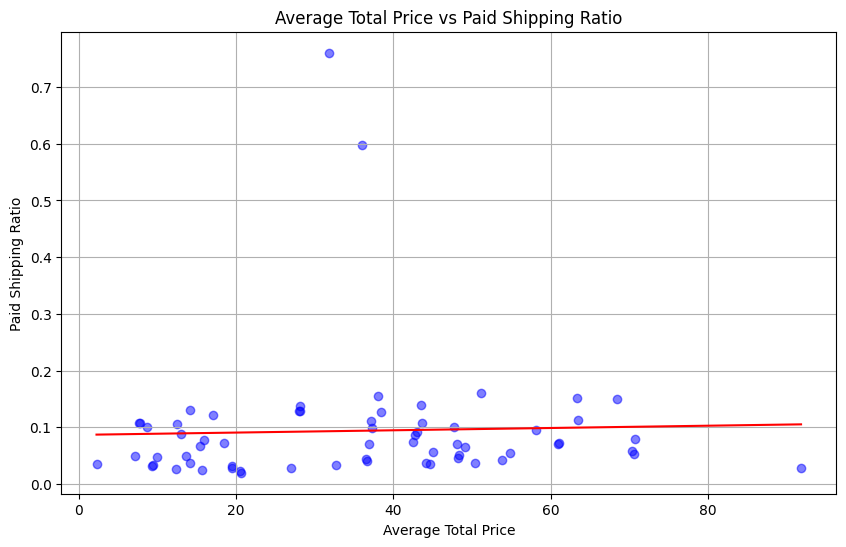

In [203]:
sorted_df = sorted_df[(sorted_df["Average Total Price"] >=0) & (sorted_df["Average Total Price"] < 100)]
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(sorted_df['Average Total Price'], sorted_df['Paid/All Ratio'], color='blue', alpha=0.5)
plt.title('Average Total Price vs Paid Shipping Ratio')
plt.xlabel('Average Total Price')
plt.ylabel('Paid Shipping Ratio')
plt.grid(True)

# Fit OLS regression line
X = sm.add_constant(sorted_df['Average Total Price'])
model = sm.OLS(sorted_df['Paid/All Ratio'], X)
results = model.fit()
plt.plot(sorted_df['Average Total Price'], results.predict(X), color='red')

plt.show()

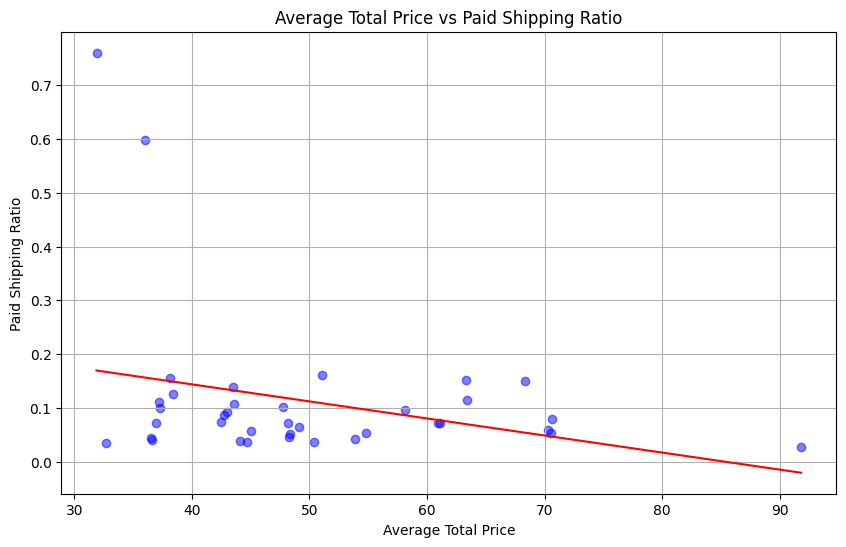

In [204]:
sorted_df = sorted_df[(sorted_df["Average Total Price"] >=30) & (sorted_df["Average Total Price"] < 100)]
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(sorted_df['Average Total Price'], sorted_df['Paid/All Ratio'], color='blue', alpha=0.5)
plt.title('Average Total Price vs Paid Shipping Ratio')
plt.xlabel('Average Total Price')
plt.ylabel('Paid Shipping Ratio')
plt.grid(True)

# Fit OLS regression line
X = sm.add_constant(sorted_df['Average Total Price'])
model = sm.OLS(sorted_df['Paid/All Ratio'], X)
results = model.fit()
plt.plot(sorted_df['Average Total Price'], results.predict(X), color='red')

plt.show()
